# Visualize Code Generation Results and Rank Models

1. 15 small language models (SLMs) were tested on 4 code generation datasets.
2. Metric used - Pass@1
3. This notebooks load raw results, visualizes them by dataset, and ranks the models based on their average performance.
4. Alternatively, it applies the MinMaxScaler to normalize the results and then rank SLMs.

__Candiates for removal__ for the reflection workflow cycle:
* Mistral 7B (lowest results)
* Mistral codestral_mamba - discontinued by Mistral AI because API call to list all the available models doesn't contain this one, only the 22B codstral model and the codestral embeddings model.
* Solar-10.7B (10.7B model, but low results).
* Phixtral-4x2_8 (duplicates the results of Phixtral-2x2_8).
* Mistral Nemo (12B model - largest among all, but it performs at the level of 7~8B models). SINCE CODESTRAL_MAMBA IS DISCONTINUED, I MIGHT AS WELL KEEP NEMO

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

# HumanEval

In [6]:
file = '/Users/andrew/Documents/04_git/code-generation/0_documents/2_docs/indiv_model_results_20250322.xlsx'
human_eval = pd.read_excel(file, sheet_name='HumanEval')
human_eval

#     dataset        prompt    cleaning  temperature  top_p  \
0    1  human_eval  basic_prompt         raw            1      1   
1    2  human_eval  basic_prompt     partial            1      1   
2    3  human_eval  basic_prompt        full            1      1   
3    4  human_eval  basic_prompt  full_light            1      1   
4    5  human_eval        prompt         raw            1      1   
5    6  human_eval        prompt     partial            1      1   
6    7  human_eval        prompt        full            1      1   
7    8  human_eval        prompt  full_light            1      1   
8    9  human_eval   full_prompt         raw            1      1   
9   10  human_eval   full_prompt     partial            1      1   
10  11  human_eval   full_prompt        full            1      1   
11  12  human_eval   full_prompt  full_light            1      1   

    phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  Llama-3.1-8B  \
0         0.500000        0.500000     0.054878      0.000000   
1         0.500000        0.500000     0.451220      0.701220   
2         0.512195        0.512195     0.451220      0.707317   
3         0.506098        0.506098     0.451220      0.701220   
4         0.024390        0.024390     0.000000      0.000000   
5         0.463415        0.463415     0.445122      0.658537   
6         0.554878        0.554878     0.445122      0.682927   
7         0.560976        0.560976     0.445122      0.670732   
8         0.048780        0.048780     0.000000      0.000000   
9         0.256098        0.256098     0.341463      0.585366   
10        0.548780        0.548780     0.414634      0.585366   
11        0.542683        0.542683     0.414634      0.585366   

    Codegemma-7b-it  deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  \
0          0.000000             0.774390                     0.743902   
1          0.609756             0.786585                     0.762195   
2          0.609756             0.780488                     0.762195   
3          0.609756             0.786585                     0.762195   
4          0.000000             0.024390                     0.006098   
5          0.554878             0.817073                     0.768293   
6          0.585366             0.810976                     0.762195   
7          0.585366             0.817073                     0.768293   
8          0.000000             0.000000                     0.000000   
9          0.512195             0.725610                     0.713415   
10         0.542683             0.725610                     0.719512   
11         0.542683             0.725610                     0.719512   

    Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  \
0                 0.750000             0.000000           0.000000   
1                 0.756098             0.817073           0.823171   
2                 0.750000             0.823171           0.829268   
3                 0.756098             0.817073           0.823171   
4                 0.725610             0.000000           0.000000   
5                 0.768293             0.786585           0.768293   
6                 0.762195             0.841463           0.829268   
7                 0.768293             0.841463           0.829268   
8                 0.609756             0.000000           0.000000   
9                 0.682927             0.756098           0.750000   
10                0.695122             0.780488           0.774390   
11                0.695122             0.780488           0.774390   

    mistral_7b  mistral_3b  mistral_8B  mistral_nemo  codestral_mamba  
0     0.000000    0.000000    0.000000      0.487805         0.439024  
1     0.420732    0.774390    0.792683      0.689024         0.737805  
2     0.420732    0.768293    0.786585      0.682927         0.762195  
3     0.420732    0.774390    0.792683      0.689024         0.762195  
4     0.000000    0.000000    0.000000      0.000000 

In [7]:
# Identify & select only the 15 SLM model columns
param_cols = ['#', 'dataset', 'prompt', 'cleaning', 'temperature', 'top_p']
score_cols = [c for c in human_eval.columns if c not in param_cols]
human_eval_scores = human_eval[score_cols].apply(pd.to_numeric, errors='coerce')

# Rebuild MultiIndex on rows from the original prompt/cleaning columns
mi = pd.MultiIndex.from_frame(human_eval[['prompt','cleaning']])
human_eval_scores.index = mi
human_eval_scores.index.names = ['prompt','cleaning']
human_eval_scores

phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  \
prompt       cleaning                                                  
basic_prompt raw               0.500000        0.500000     0.054878   
             partial           0.500000        0.500000     0.451220   
             full              0.512195        0.512195     0.451220   
             full_light        0.506098        0.506098     0.451220   
prompt       raw               0.024390        0.024390     0.000000   
             partial           0.463415        0.463415     0.445122   
             full              0.554878        0.554878     0.445122   
             full_light        0.560976        0.560976     0.445122   
full_prompt  raw               0.048780        0.048780     0.000000   
             partial           0.256098        0.256098     0.341463   
             full              0.548780        0.548780     0.414634   
             full_light        0.542683        0.542683     0.414634   

                         Llama-3.1-8B  Codegemma-7b-it  deepseek-coder-6.7b  \
prompt       cleaning                                                         
basic_prompt raw             0.000000         0.000000             0.774390   
             partial         0.701220         0.609756             0.786585   
             full            0.707317         0.609756             0.780488   
             full_light      0.701220         0.609756             0.786585   
prompt       raw             0.000000         0.000000             0.024390   
             partial         0.658537         0.554878             0.817073   
             full            0.682927         0.585366             0.810976   
             full_light      0.670732         0.585366             0.817073   
full_prompt  raw             0.000000         0.000000             0.000000   
             partial         0.585366         0.512195             0.725610   
             full            0.585366         0.542683             0.725610   
             full_light      0.585366         0.542683             0.725610   

                         OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
prompt       cleaning                                                          
basic_prompt raw                            0.743902                0.750000   
             partial                        0.762195                0.756098   
             full                           0.762195                0.750000   
             full_light                     0.762195                0.756098   
prompt       raw                            0.006098                0.725610   
             partial                        0.768293                0.768293   
             full                           0.762195                0.762195   
             full_light                     0.768293                0.768293   
full_prompt  raw                            0.000000                0.609756   
             partial                        0.713415                0.682927   
             full                           0.719512                0.695122   
             full_light                     0.719512                0.695122   

                         CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
prompt       cleaning                                                         
basic_prompt raw                    0.000000           0.000000    0.000000   
             partial                0.817073           0.823171    0.420732   
             full                   0.823171           0.829268    0.420732   
             full_light             0.817073           0.823171    0.420732   
prompt       raw                    0.000000           0.000000    0.000000   
             partial                0.786585           0.768293    0.317073   
             full                   0.841463           0.829268    0.359756   
             full_light             0.841463           0.829268    0.359756  

In [8]:
# generic name not to re-write code for each dataset
df = human_eval_scores

In [15]:
prompt = 'basic_prompt'
clean = 'full_light'
#df.loc[(prompt, clean), sorted_models].values
df.loc[ (prompt, clean), sorted_models ]

mistral_7b                     0.420732
Solar-10.7B                    0.451220
phixtral-2x2_8                 0.506098
phixtral-4x2_8                 0.506098
Codegemma-7b-it                0.609756
mistral_nemo                   0.689024
Llama-3.1-8B                   0.701220
Artigenz-Coder-DS-6.7B         0.756098
OpenCodeInterpreter-DS-6.7B    0.762195
codestral_mamba                0.762195
mistral_3b                     0.774390
deepseek-coder-6.7b            0.786585
mistral_8B                     0.792683
CodeQwen1.5-7B-Chat            0.817073
Nxcode-CQ-7B-orpo              0.823171
Name: (basic_prompt, full_light), dtype: float64

basic_prompt


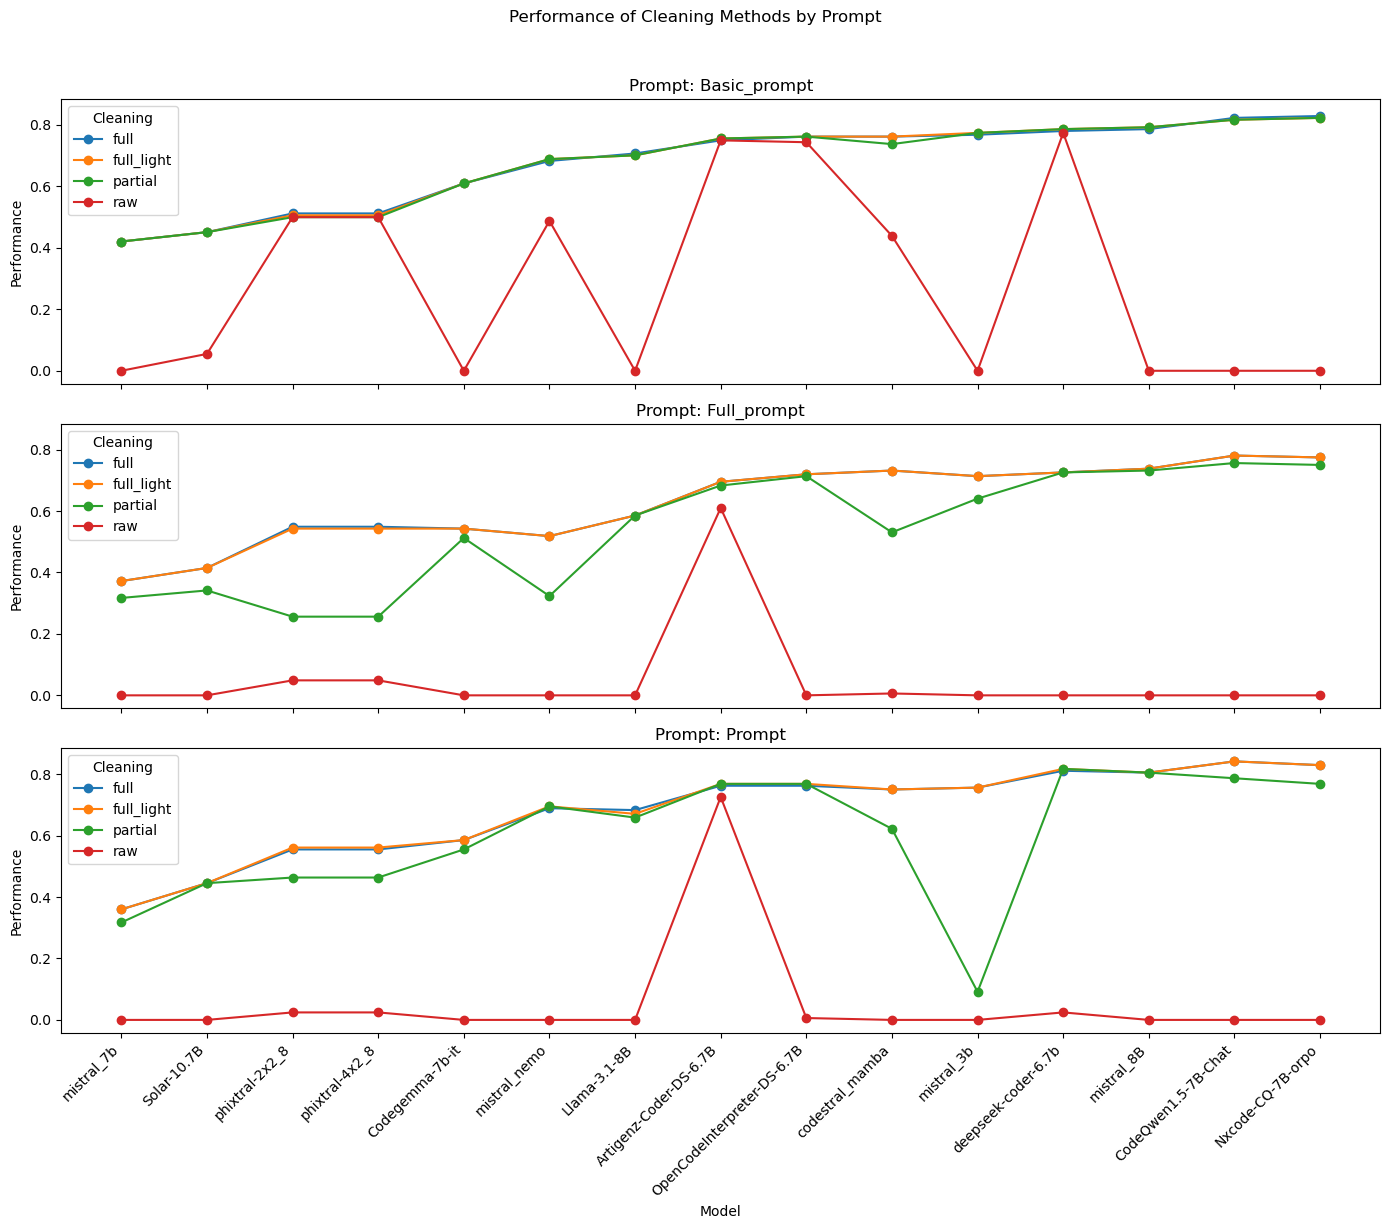

In [16]:
prompts   = df.index.levels[0]
cleanings = df.index.levels[1]

# get the first prompt ('basic_prompt') and sort by 'full' cleaning
first_prompt   = prompts[0]
print(first_prompt)
y_full_clean   = df.loc[(first_prompt, 'full')]                    # Series indexed by model_cols
sorted_models  = y_full_clean.sort_values().index.tolist()         # ascending order

# plot each prompt using that sorted_models on the x-axis
fig, axes = plt.subplots(len(prompts), 1,
                         figsize=(14, 4 * len(prompts)),
                         sharex=True, sharey=True)

for ax, prompt in zip(axes, prompts):
    for clean in cleanings:
        # grab and re-order the y-values by sorted_models
        y = df.loc[(prompt, clean), sorted_models]
        ax.plot(range(len(sorted_models)), y, marker='o', label=clean)

    ax.set_title(f'Prompt: {prompt.capitalize()}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Performance')
    ax.legend(title='Cleaning')

# only label the bottom x-axis
axes[-1].set_xlabel('Model')

fig.suptitle('Performance of Cleaning Methods by Prompt', y=1.02)
plt.tight_layout()
plt.show()

full


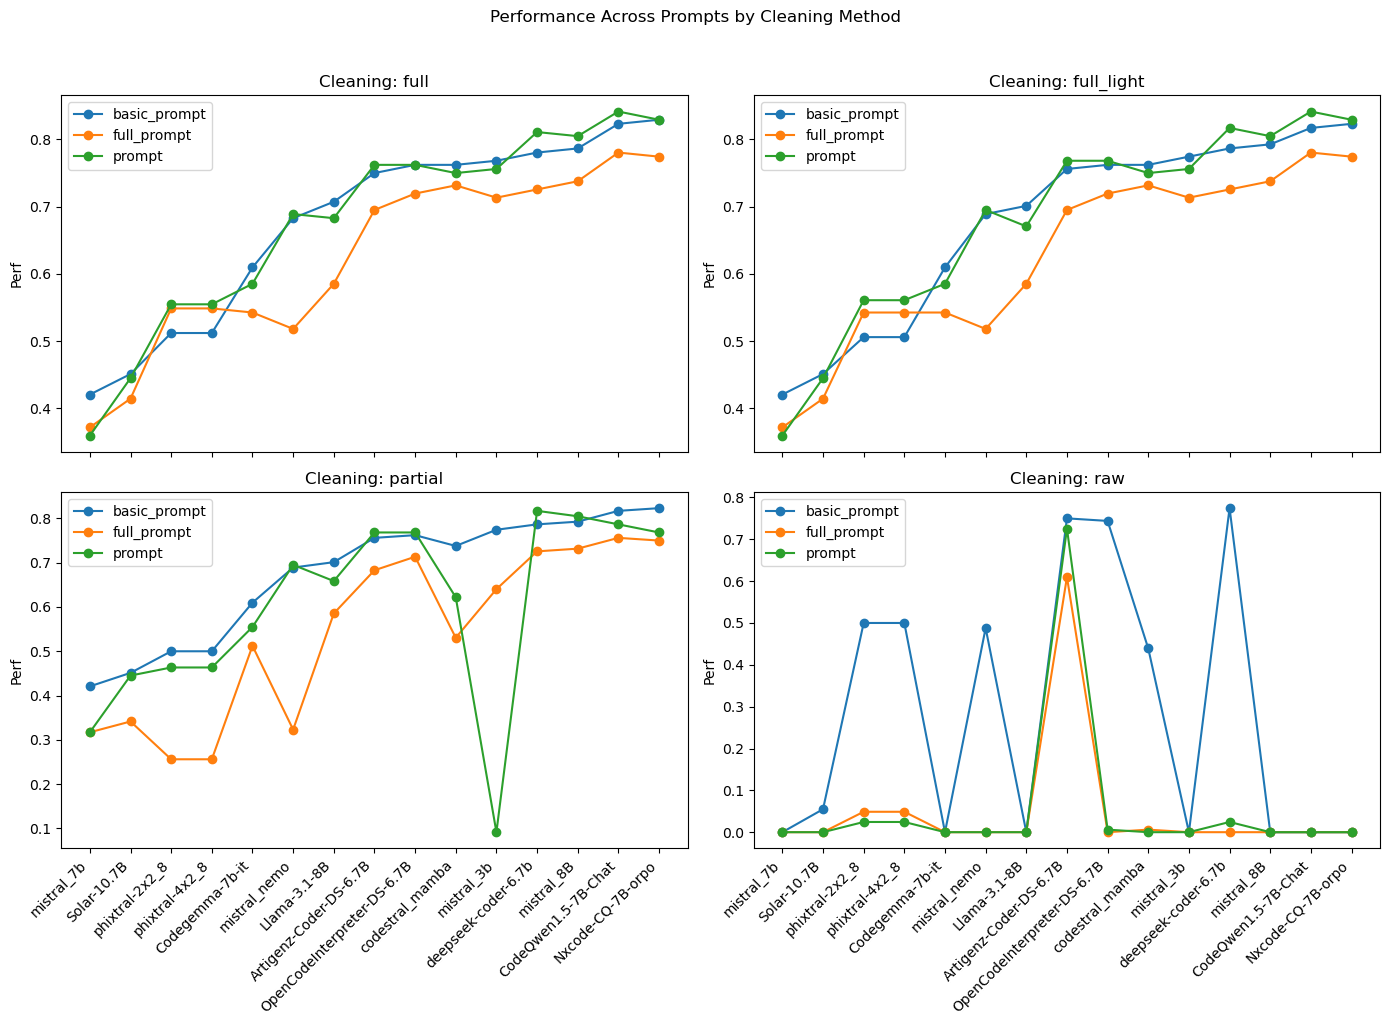

In [13]:
cleanings = df.index.levels[1]
prompts   = df.index.levels[0]

# get the first cleaning ('full') and sort by basic_prompt
first_clean = cleanings[0]
print(first_clean)
y_basic = df.loc[("basic_prompt", first_clean)]               # Series indexed by score_cols
sorted_models = y_basic.sort_values().index.tolist()            # ascending order of basic_prompt

# plot using that same sorted_models order
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

for ax, clean in zip(axes.flatten(), cleanings):
    for prompt in prompts:
        y = df.loc[(prompt, clean), sorted_models].values
        ax.plot(range(len(sorted_models)), y, marker='o', label=prompt)
    ax.set_title(f'Cleaning: {clean}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Perf')
    ax.legend()

fig.suptitle('Performance Across Prompts by Cleaning Method', y=1.02)
plt.tight_layout()
plt.show()

In [17]:
row_means = df.mean(axis=1)
print(row_means)

prompt        cleaning  
basic_prompt  raw           0.283333
              partial       0.674797
              full          0.677236
              full_light    0.677236
prompt        raw           0.053659
              partial       0.601626
              full          0.679268
              full_light    0.680894
full_prompt   raw           0.047561
              partial       0.541463
              full          0.627236
              full_light    0.626423
dtype: float64


In [18]:
row_max = df.max(axis=1)
print(row_max)

prompt        cleaning  
basic_prompt  raw           0.774390
              partial       0.823171
              full          0.829268
              full_light    0.823171
prompt        raw           0.725610
              partial       0.817073
              full          0.841463
              full_light    0.841463
full_prompt   raw           0.609756
              partial       0.756098
              full          0.780488
              full_light    0.780488
dtype: float64


In [19]:
# compute column‐wise means and maxima
col_means = df.mean(axis=0).sort_values()
col_maxes = df.max(axis=0).sort_values()

# print each Series (index = model names)
print("Column‐wise means:\n", col_means, "\n", sep='')
print("Column‐wise maxima:\n", col_maxes, "\n", sep='')

max_locs = df.idxmax(axis=0)
print("Max locations:\n", max_locs, sep='')

Column‐wise means:
mistral_7b                     0.279980
Solar-10.7B                    0.326220
phixtral-2x2_8                 0.418191
phixtral-4x2_8                 0.418191
Codegemma-7b-it                0.429370
Llama-3.1-8B                   0.489837
mistral_nemo                   0.498984
mistral_3b                     0.498984
codestral_mamba                0.568598
mistral_8B                     0.582825
Nxcode-CQ-7B-orpo              0.600102
CodeQwen1.5-7B-Chat            0.603659
OpenCodeInterpreter-DS-6.7B    0.623984
deepseek-coder-6.7b            0.647866
Artigenz-Coder-DS-6.7B         0.726626
dtype: float64

Column‐wise maxima:
mistral_7b                     0.420732
Solar-10.7B                    0.451220
phixtral-2x2_8                 0.560976
phixtral-4x2_8                 0.560976
Codegemma-7b-it                0.609756
mistral_nemo                   0.695122
Llama-3.1-8B                   0.707317
codestral_mamba                0.762195
OpenCodeInterpreter-DS-6.

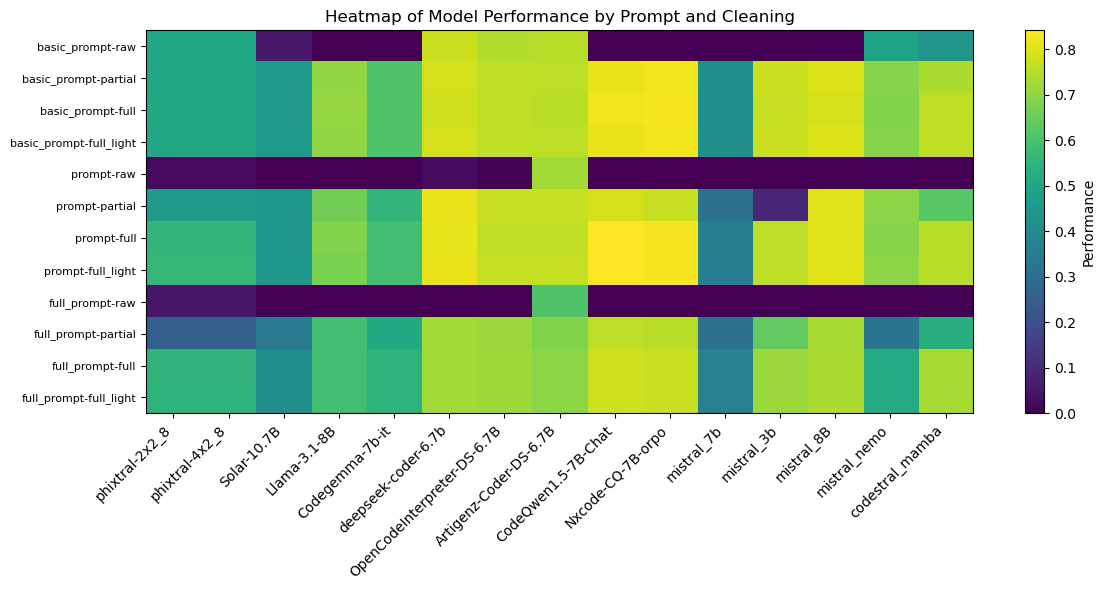

In [20]:
# Heatmap
plt.figure(figsize=(12,6))
plt.imshow(df.values.astype(float), aspect='auto', cmap='viridis')
plt.colorbar(label='Performance')
plt.xticks(range(len(score_cols)), score_cols, rotation=45, ha='right')
plt.yticks(range(len(df.index)), [f"{p}-{c}" for p,c in df.index], fontsize=8)
plt.title('Heatmap of Model Performance by Prompt and Cleaning')
plt.tight_layout()
plt.show()

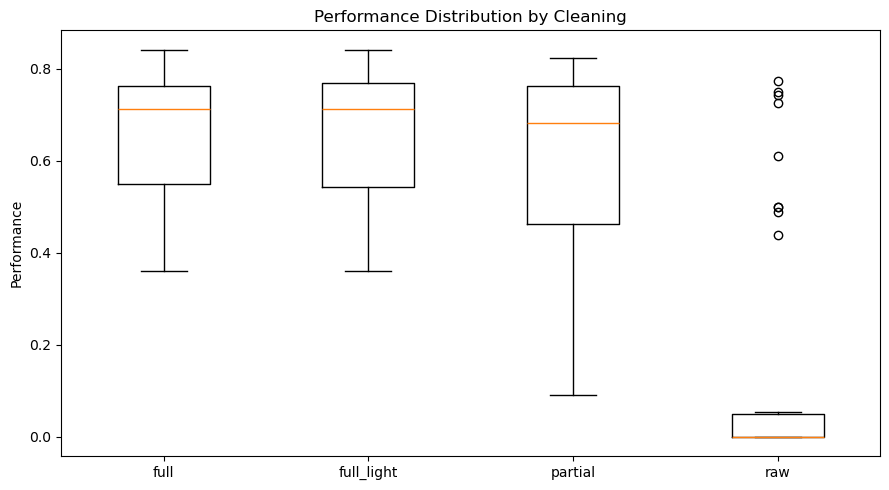

In [21]:
plt.figure(figsize=(9,5))
plt.boxplot([df.xs(c, level='cleaning').values.flatten() for c in cleanings],
            labels=cleanings)
plt.title('Performance Distribution by Cleaning')
plt.ylabel('Performance')
plt.tight_layout()
plt.show()

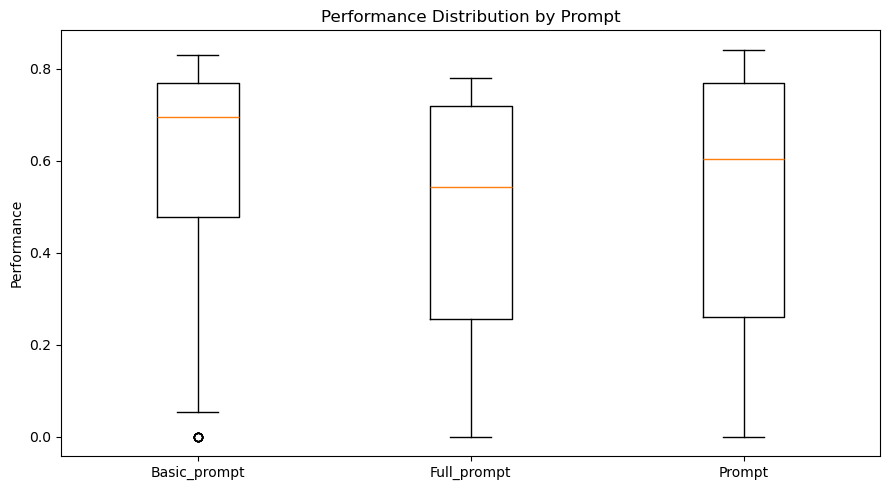

In [22]:
# Boxplots
plt.figure(figsize=(9,5))
plt.boxplot([df.loc[p].values.flatten() for p in prompts],
            labels=[p.capitalize() for p in prompts])
plt.title('Performance Distribution by Prompt')
plt.ylabel('Performance')
plt.tight_layout()
plt.show()

## Bigcode

In [23]:
file = '/Users/andrew/Documents/04_git/code-generation/0_documents/2_docs/indiv_model_results_20250322.xlsx'
big_code = pd.read_excel(file, sheet_name='BigCode')
big_code

#   dataset        prompt    cleaning  temperature  top_p  \
0    1  big_code  basic_prompt         raw            1      1   
1    2  big_code  basic_prompt     partial            1      1   
2    3  big_code  basic_prompt        full            1      1   
3    4  big_code  basic_prompt  full_light            1      1   
4    5  big_code        prompt         raw            1      1   
5    6  big_code        prompt     partial            1      1   
6    7  big_code        prompt        full            1      1   
7    8  big_code        prompt  full_light            1      1   
8    9  big_code   full_prompt         raw            1      1   
9   10  big_code   full_prompt     partial            1      1   
10  11  big_code   full_prompt        full            1      1   
11  12  big_code   full_prompt  full_light            1      1   

    phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  Llama-3.1-8B  \
0            0.114           0.114        0.066         0.000   
1            0.118           0.116        0.260         0.218   
2            0.222           0.224        0.264         0.248   
3            0.148           0.150        0.262         0.226   
4            0.002           0.002        0.000         0.000   
5            0.262           0.262        0.274         0.206   
6            0.274           0.274        0.274         0.242   
7            0.270           0.270        0.274         0.208   
8            0.016           0.016        0.000         0.002   
9            0.030           0.030        0.284         0.300   
10           0.228           0.228        0.264         0.298   
11           0.200           0.200        0.264         0.298   

    Codegemma-7b-it  deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  \
0             0.000                0.090                        0.132   
1             0.266                0.254                        0.222   
2             0.268                0.278                        0.252   
3             0.268                0.254                        0.224   
4             0.000                0.000                        0.000   
5             0.282                0.260                        0.280   
6             0.280                0.298                        0.290   
7             0.280                0.268                        0.286   
8             0.000                0.002                        0.002   
9             0.264                0.126                        0.148   
10            0.248                0.280                        0.210   
11            0.248                0.280                        0.208   

    Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  \
0                    0.272                0.000              0.000   
1                    0.274                0.288              0.280   
2                    0.284                0.290              0.280   
3                    0.274                0.288              0.280   
4                    0.040                0.000              0.000   
5                    0.250                0.298              0.292   
6                    0.278                0.292              0.288   
7                    0.254                0.292              0.286   
8                    0.016                0.008              0.008   
9                    0.226                0.220              0.218   
10                   0.236                0.208              0.204   
11                   0.230                0.208              0.204   

    mistral_7b  mistral_3b  mistral_8B  mistral_nemo  codestral_mamba  
0        0.000       0.000       0.000         0.002            0.080  
1        0.332       0.330       0.330         0.306            0.300  
2        0.324       0.332       0.332         0.320            0.320  
3        0.322       0.330       0.330         0.308            0.302  
4        0.000       0.000       0.000         0.000            0.004  
5      

In [24]:
# Identify & select only the 15 SLM model columns
param_cols = ['#', 'dataset', 'prompt', 'cleaning', 'temperature', 'top_p']
score_cols = [c for c in big_code.columns if c not in param_cols]
big_code_scores = big_code[score_cols].apply(pd.to_numeric, errors='coerce')

# Rebuild MultiIndex on rows from the original prompt/cleaning columns
mi = pd.MultiIndex.from_frame(big_code[['prompt','cleaning']])
big_code_scores.index = mi
big_code_scores.index.names = ['prompt','cleaning']
big_code_scores

phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  \
prompt       cleaning                                                  
basic_prompt raw                  0.114           0.114        0.066   
             partial              0.118           0.116        0.260   
             full                 0.222           0.224        0.264   
             full_light           0.148           0.150        0.262   
prompt       raw                  0.002           0.002        0.000   
             partial              0.262           0.262        0.274   
             full                 0.274           0.274        0.274   
             full_light           0.270           0.270        0.274   
full_prompt  raw                  0.016           0.016        0.000   
             partial              0.030           0.030        0.284   
             full                 0.228           0.228        0.264   
             full_light           0.200           0.200        0.264   

                         Llama-3.1-8B  Codegemma-7b-it  deepseek-coder-6.7b  \
prompt       cleaning                                                         
basic_prompt raw                0.000            0.000                0.090   
             partial            0.218            0.266                0.254   
             full               0.248            0.268                0.278   
             full_light         0.226            0.268                0.254   
prompt       raw                0.000            0.000                0.000   
             partial            0.206            0.282                0.260   
             full               0.242            0.280                0.298   
             full_light         0.208            0.280                0.268   
full_prompt  raw                0.002            0.000                0.002   
             partial            0.300            0.264                0.126   
             full               0.298            0.248                0.280   
             full_light         0.298            0.248                0.280   

                         OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
prompt       cleaning                                                          
basic_prompt raw                               0.132                   0.272   
             partial                           0.222                   0.274   
             full                              0.252                   0.284   
             full_light                        0.224                   0.274   
prompt       raw                               0.000                   0.040   
             partial                           0.280                   0.250   
             full                              0.290                   0.278   
             full_light                        0.286                   0.254   
full_prompt  raw                               0.002                   0.016   
             partial                           0.148                   0.226   
             full                              0.210                   0.236   
             full_light                        0.208                   0.230   

                         CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
prompt       cleaning                                                         
basic_prompt raw                       0.000              0.000       0.000   
             partial                   0.288              0.280       0.332   
             full                      0.290              0.280       0.324   
             full_light                0.288              0.280       0.322   
prompt       raw                       0.000              0.000       0.000   
             partial                   0.298              0.292       0.354   
             full                      0.292              0.288       0.328   
             full_light                0.292              0.286       0.328  

In [35]:
# generic name not to re-write code for each dataset
df = big_code_scores

In [36]:
prompt = 'basic_prompt'
clean = 'full_light'
#df.loc[(prompt, clean), sorted_models].values
df.loc[ (prompt, clean), sorted_models ]

mistral_7b                     0.322
Solar-10.7B                    0.262
phixtral-2x2_8                 0.148
phixtral-4x2_8                 0.150
Codegemma-7b-it                0.268
mistral_nemo                   0.308
Llama-3.1-8B                   0.226
Artigenz-Coder-DS-6.7B         0.274
OpenCodeInterpreter-DS-6.7B    0.224
codestral_mamba                0.302
mistral_3b                     0.330
deepseek-coder-6.7b            0.254
mistral_8B                     0.330
CodeQwen1.5-7B-Chat            0.288
Nxcode-CQ-7B-orpo              0.280
Name: (basic_prompt, full_light), dtype: float64

basic_prompt


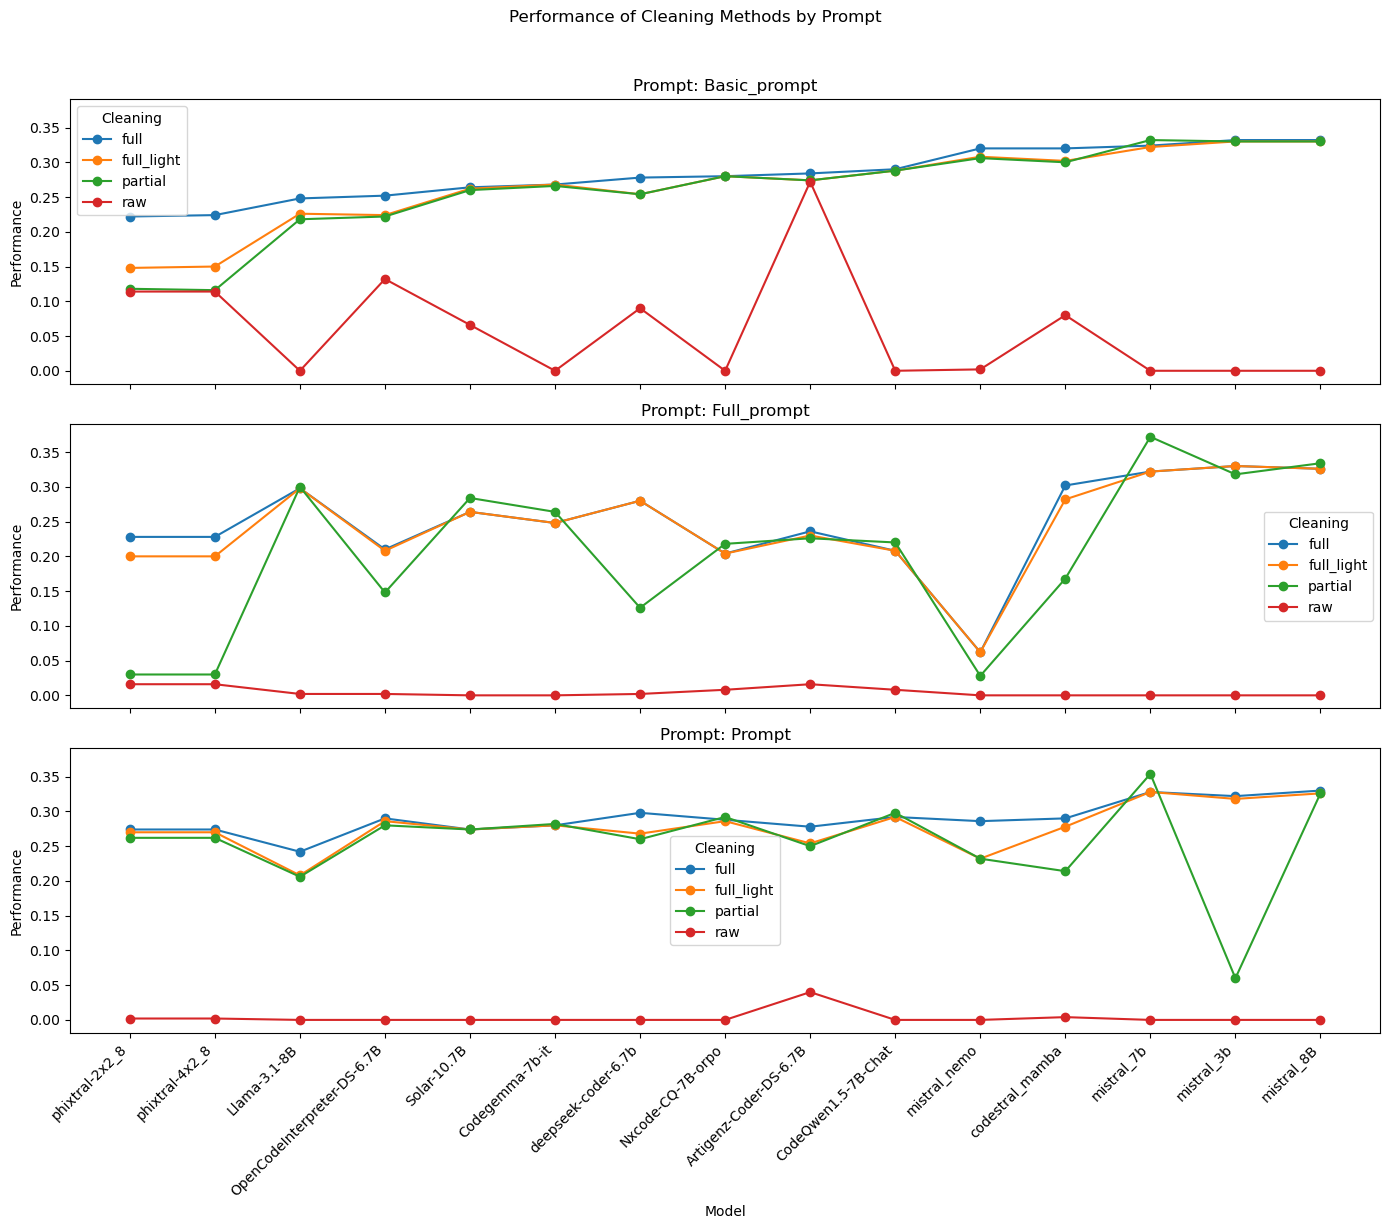

In [37]:
prompts   = df.index.levels[0]
cleanings = df.index.levels[1]

# get the first prompt ('basic_prompt') and sort by 'full' cleaning
first_prompt   = prompts[0]
print(first_prompt)
y_full_clean   = df.loc[(first_prompt, 'full')]                    # Series indexed by model_cols
sorted_models  = y_full_clean.sort_values().index.tolist()         # ascending order

# plot each prompt using that sorted_models on the x-axis
fig, axes = plt.subplots(len(prompts), 1,
                         figsize=(14, 4 * len(prompts)),
                         sharex=True, sharey=True)

for ax, prompt in zip(axes, prompts):
    for clean in cleanings:
        # grab and re-order the y-values by sorted_models
        y = df.loc[(prompt, clean), sorted_models]
        ax.plot(range(len(sorted_models)), y, marker='o', label=clean)

    ax.set_title(f'Prompt: {prompt.capitalize()}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Performance')
    ax.legend(title='Cleaning')

# only label the bottom x-axis
axes[-1].set_xlabel('Model')

fig.suptitle('Performance of Cleaning Methods by Prompt', y=1.02)
plt.tight_layout()
plt.show()

full


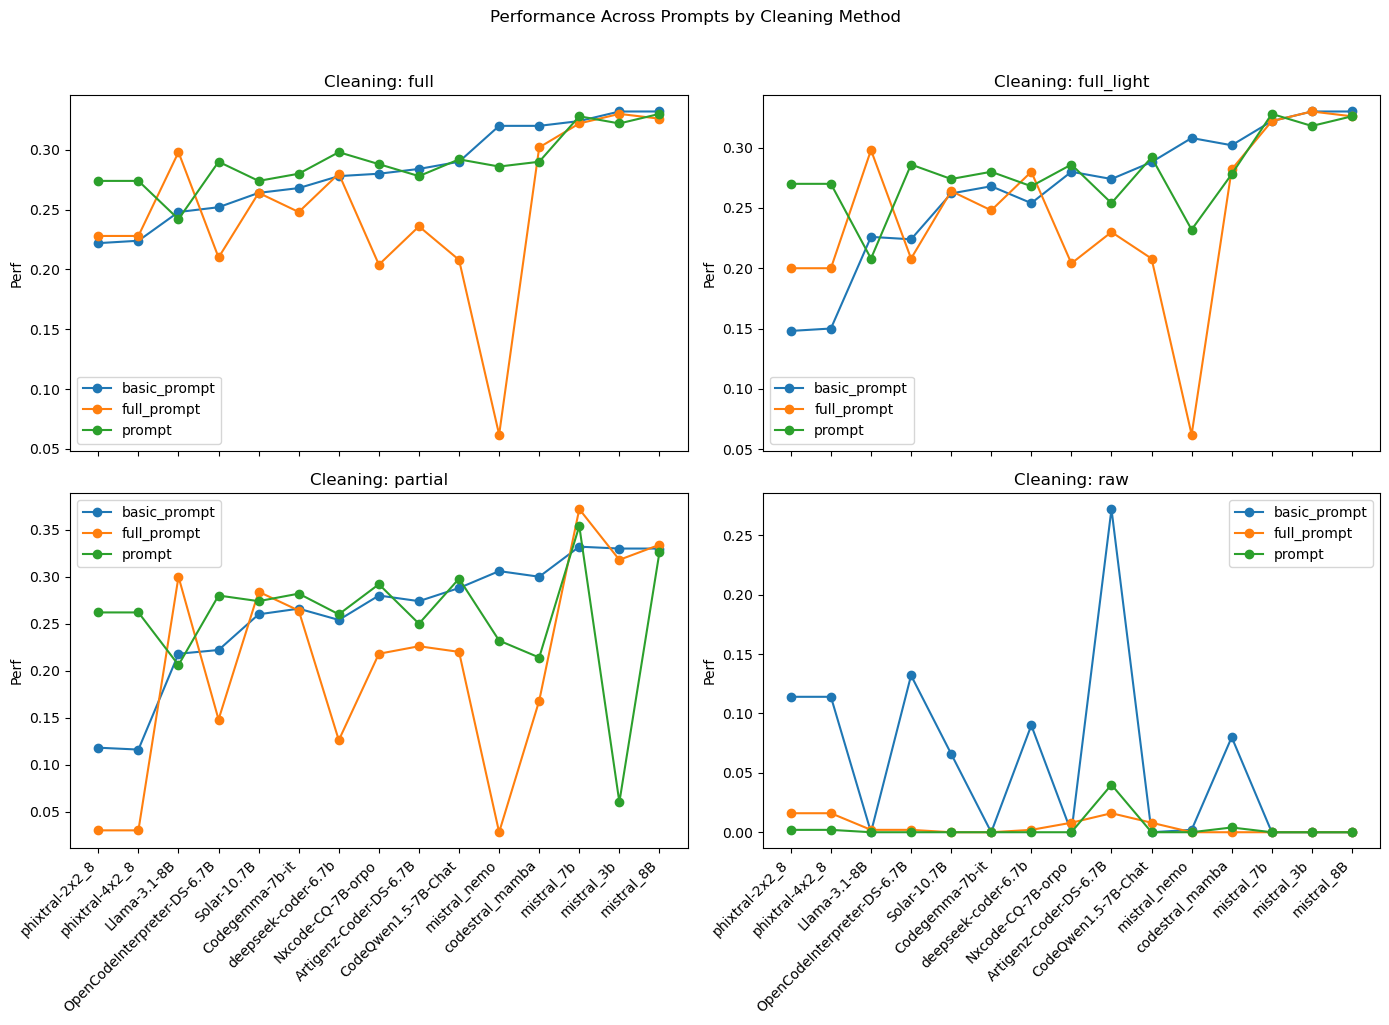

In [38]:
cleanings = df.index.levels[1]
prompts   = df.index.levels[0]

# get the first cleaning ('full') and sort by basic_prompt
first_clean = cleanings[0]
print(first_clean)
y_basic = df.loc[("basic_prompt", first_clean)]               # Series indexed by score_cols
sorted_models = y_basic.sort_values().index.tolist()            # ascending order of basic_prompt

# plot using that same sorted_models order
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

for ax, clean in zip(axes.flatten(), cleanings):
    for prompt in prompts:
        y = df.loc[(prompt, clean), sorted_models].values
        ax.plot(range(len(sorted_models)), y, marker='o', label=prompt)
    ax.set_title(f'Cleaning: {clean}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Perf')
    ax.legend()

fig.suptitle('Performance Across Prompts by Cleaning Method', y=1.02)
plt.tight_layout()
plt.show()

In [39]:
row_means = df.mean(axis=1)
print(row_means)

prompt        cleaning  
basic_prompt  raw           0.058000
              partial       0.259600
              full          0.282533
              full_light    0.264400
prompt        raw           0.003200
              partial       0.256800
              full          0.289733
              full_light    0.278000
full_prompt   raw           0.004667
              partial       0.204400
              full          0.249733
              full_light    0.244133
dtype: float64


In [40]:
row_max = df.max(axis=1)
print(row_max)

prompt        cleaning  
basic_prompt  raw           0.272
              partial       0.332
              full          0.332
              full_light    0.330
prompt        raw           0.040
              partial       0.354
              full          0.330
              full_light    0.328
full_prompt   raw           0.016
              partial       0.372
              full          0.330
              full_light    0.330
dtype: float64


In [41]:
# compute column‐wise means and maxima
col_means = df.mean(axis=0).sort_values()
col_maxes = df.max(axis=0).sort_values()

# print each Series (index = model names)
print("Column‐wise means:\n", col_means, "\n", sep='')
print("Column‐wise maxima:\n", col_maxes, "\n", sep='')

max_locs = df.idxmax(axis=0)
print("Max locations:\n", max_locs, sep='')

Column‐wise means:
mistral_nemo                   0.153167
phixtral-2x2_8                 0.157000
phixtral-4x2_8                 0.157167
Llama-3.1-8B                   0.187167
OpenCodeInterpreter-DS-6.7B    0.187833
Nxcode-CQ-7B-orpo              0.195000
deepseek-coder-6.7b            0.199167
CodeQwen1.5-7B-Chat            0.199333
Codegemma-7b-it                0.200333
Solar-10.7B                    0.207167
codestral_mamba                0.211667
Artigenz-Coder-DS-6.7B         0.219500
mistral_3b                     0.222500
mistral_8B                     0.246667
mistral_7b                     0.250333
dtype: float64

Column‐wise maxima:
phixtral-2x2_8                 0.274
phixtral-4x2_8                 0.274
Codegemma-7b-it                0.282
Solar-10.7B                    0.284
Artigenz-Coder-DS-6.7B         0.284
OpenCodeInterpreter-DS-6.7B    0.290
Nxcode-CQ-7B-orpo              0.292
deepseek-coder-6.7b            0.298
CodeQwen1.5-7B-Chat            0.298
Llama-3.1-8B

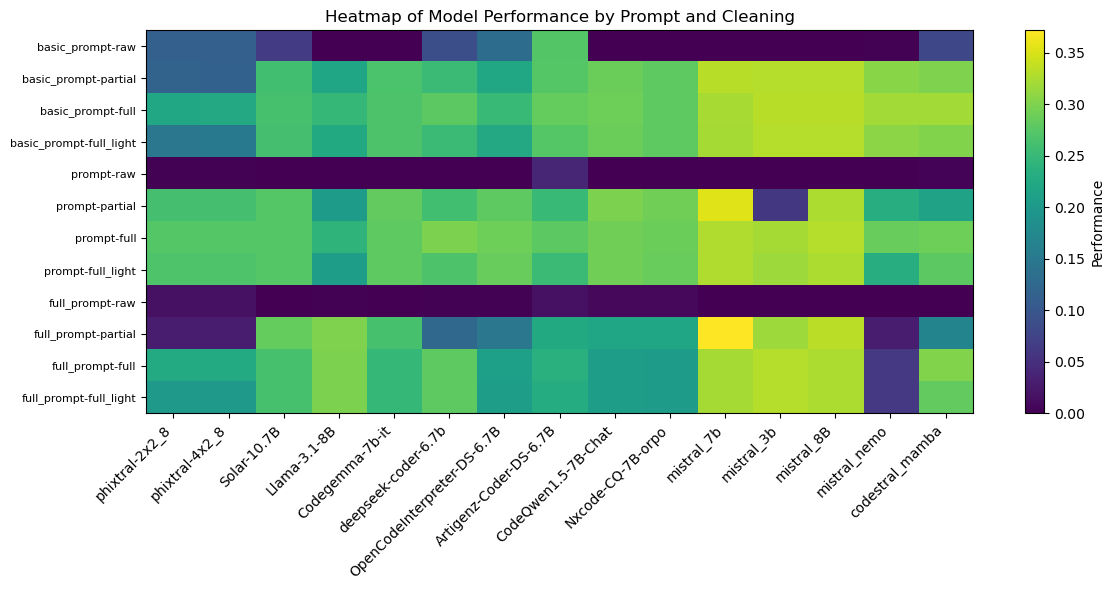

In [42]:
# Heatmap
plt.figure(figsize=(12,6))
plt.imshow(df.values.astype(float), aspect='auto', cmap='viridis')
plt.colorbar(label='Performance')
plt.xticks(range(len(score_cols)), score_cols, rotation=45, ha='right')
plt.yticks(range(len(df.index)), [f"{p}-{c}" for p,c in df.index], fontsize=8)
plt.title('Heatmap of Model Performance by Prompt and Cleaning')
plt.tight_layout()
plt.show()

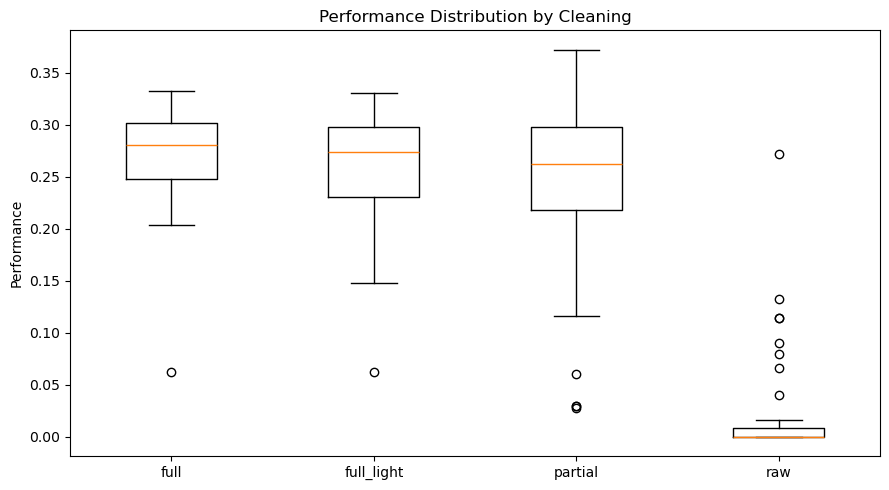

In [43]:
plt.figure(figsize=(9,5))
plt.boxplot([df.xs(c, level='cleaning').values.flatten() for c in cleanings],
            labels=cleanings)
plt.title('Performance Distribution by Cleaning')
plt.ylabel('Performance')
plt.tight_layout()
plt.show()

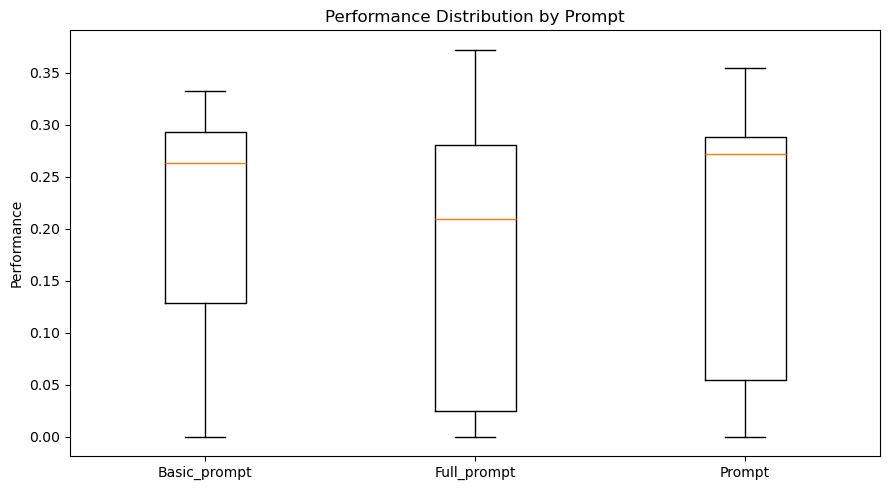

In [44]:
# Boxplots
plt.figure(figsize=(9,5))
plt.boxplot([df.loc[p].values.flatten() for p in prompts],
            labels=[p.capitalize() for p in prompts])
plt.title('Performance Distribution by Prompt')
plt.ylabel('Performance')
plt.tight_layout()
plt.show()

# LBPP

In [109]:
file = '/Users/andrew/Documents/04_git/code-generation/0_documents/2_docs/indiv_model_results_20250322.xlsx'
lbpp = pd.read_excel(file, sheet_name='LBPP')
lbpp

# dataset        prompt    cleaning  temperature  top_p  phixtral-2x2_8  \
0    1    lbpp  basic_prompt         raw            1      1        0.030864   
1    2    lbpp  basic_prompt     partial            1      1        0.172840   
2    3    lbpp  basic_prompt        full            1      1        0.166667   
3    4    lbpp  basic_prompt  full_light            1      1        0.179012   
4    5    lbpp        prompt         raw            1      1        0.000000   
5    6    lbpp        prompt     partial            1      1        0.166667   
6    7    lbpp        prompt        full            1      1        0.166667   
7    8    lbpp        prompt  full_light            1      1        0.166667   
8    9    lbpp   full_prompt         raw            1      1        0.000000   
9   10    lbpp   full_prompt     partial            1      1        0.148148   
10  11    lbpp   full_prompt        full            1      1        0.148148   
11  12    lbpp   full_prompt  full_light            1      1        0.154321   

    phixtral-4x2_8  Solar-10.7B  Llama-3.1-8B  Codegemma-7b-it  \
0         0.030864     0.018519      0.000000         0.000000   
1         0.172840     0.074074      0.296296         0.185185   
2         0.166667     0.117284      0.283951         0.185185   
3         0.179012     0.117284      0.296296         0.191358   
4         0.000000     0.000000      0.000000         0.000000   
5         0.166667     0.074074      0.228395         0.160494   
6         0.166667     0.098765      0.185185         0.203704   
7         0.166667     0.098765      0.228395         0.203704   
8         0.000000     0.000000      0.000000         0.000000   
9         0.148148     0.055556      0.216049         0.172840   
10        0.148148     0.098765      0.259259         0.222222   
11        0.154321     0.098765      0.259259         0.222222   

    deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
0              0.000000                     0.006173                0.000000   
1              0.234568                     0.277778                0.296296   
2              0.234568                     0.283951                0.290123   
3              0.234568                     0.277778                0.296296   
4              0.000000                     0.000000                0.000000   
5              0.222222                     0.259259                0.271605   
6              0.228395                     0.246914                0.283951   
7              0.228395                     0.259259                0.271605   
8              0.000000                     0.000000                0.000000   
9              0.228395                     0.253086                0.277778   
10             0.234568                     0.253086                0.265432   
11             0.234568                     0.253086                0.277778   

    CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  mistral_3b  \
0              0.000000           0.000000    0.000000    0.000000   
1              0.234568           0.228395    0.111111    0.234568   
2              0.234568           0.228395    0.123457    0.209877   
3              0.234568           0.228395    0.117284    0.234568   
4              0.000000           0.000000    0.000000    0.000000   
5              0.240741           0.228395    0.129630    0.111111   
6              0.240741           0.234568    0.141975    0.197531   
7              0.240741           0.228395    0.141975    0.234568   
8              0.000000           0.000000    0.000000    0.000000   
9              0.222222           0.197531    0.080247    0.179012   
10             0.234568           0.228395    0.080247    0.209877   
11             0.234568           0.228395    0.080247    0.209877   

    mistral_8B  mistral_nemo  codestral_mamba  
0     0.000000      0.000000         0.000000  
1     0.290123      0.228395         0.246914  
2     0.2

In [110]:
# Identify & select only the 15 SLM model columns
param_cols = ['#', 'dataset', 'prompt', 'cleaning', 'temperature', 'top_p']
score_cols = [c for c in lbpp.columns if c not in param_cols]
lbpp_scores = lbpp[score_cols].apply(pd.to_numeric, errors='coerce')

# Rebuild MultiIndex on rows from the original prompt/cleaning columns
mi = pd.MultiIndex.from_frame(lbpp[['prompt','cleaning']])
lbpp_scores.index = mi
lbpp_scores.index.names = ['prompt','cleaning']
lbpp_scores

phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  \
prompt       cleaning                                                  
basic_prompt raw               0.030864        0.030864     0.018519   
             partial           0.172840        0.172840     0.074074   
             full              0.166667        0.166667     0.117284   
             full_light        0.179012        0.179012     0.117284   
prompt       raw               0.000000        0.000000     0.000000   
             partial           0.166667        0.166667     0.074074   
             full              0.166667        0.166667     0.098765   
             full_light        0.166667        0.166667     0.098765   
full_prompt  raw               0.000000        0.000000     0.000000   
             partial           0.148148        0.148148     0.055556   
             full              0.148148        0.148148     0.098765   
             full_light        0.154321        0.154321     0.098765   

                         Llama-3.1-8B  Codegemma-7b-it  deepseek-coder-6.7b  \
prompt       cleaning                                                         
basic_prompt raw             0.000000         0.000000             0.000000   
             partial         0.296296         0.185185             0.234568   
             full            0.283951         0.185185             0.234568   
             full_light      0.296296         0.191358             0.234568   
prompt       raw             0.000000         0.000000             0.000000   
             partial         0.228395         0.160494             0.222222   
             full            0.185185         0.203704             0.228395   
             full_light      0.228395         0.203704             0.228395   
full_prompt  raw             0.000000         0.000000             0.000000   
             partial         0.216049         0.172840             0.228395   
             full            0.259259         0.222222             0.234568   
             full_light      0.259259         0.222222             0.234568   

                         OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
prompt       cleaning                                                          
basic_prompt raw                            0.006173                0.000000   
             partial                        0.277778                0.296296   
             full                           0.283951                0.290123   
             full_light                     0.277778                0.296296   
prompt       raw                            0.000000                0.000000   
             partial                        0.259259                0.271605   
             full                           0.246914                0.283951   
             full_light                     0.259259                0.271605   
full_prompt  raw                            0.000000                0.000000   
             partial                        0.253086                0.277778   
             full                           0.253086                0.265432   
             full_light                     0.253086                0.277778   

                         CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
prompt       cleaning                                                         
basic_prompt raw                    0.000000           0.000000    0.000000   
             partial                0.234568           0.228395    0.111111   
             full                   0.234568           0.228395    0.123457   
             full_light             0.234568           0.228395    0.117284   
prompt       raw                    0.000000           0.000000    0.000000   
             partial                0.240741           0.228395    0.129630   
             full                   0.240741           0.234568    0.141975   
             full_light             0.240741           0.228395    0.141975  

In [4]:
# generic name not to re-write code for each dataset
df = lbpp_scores

full


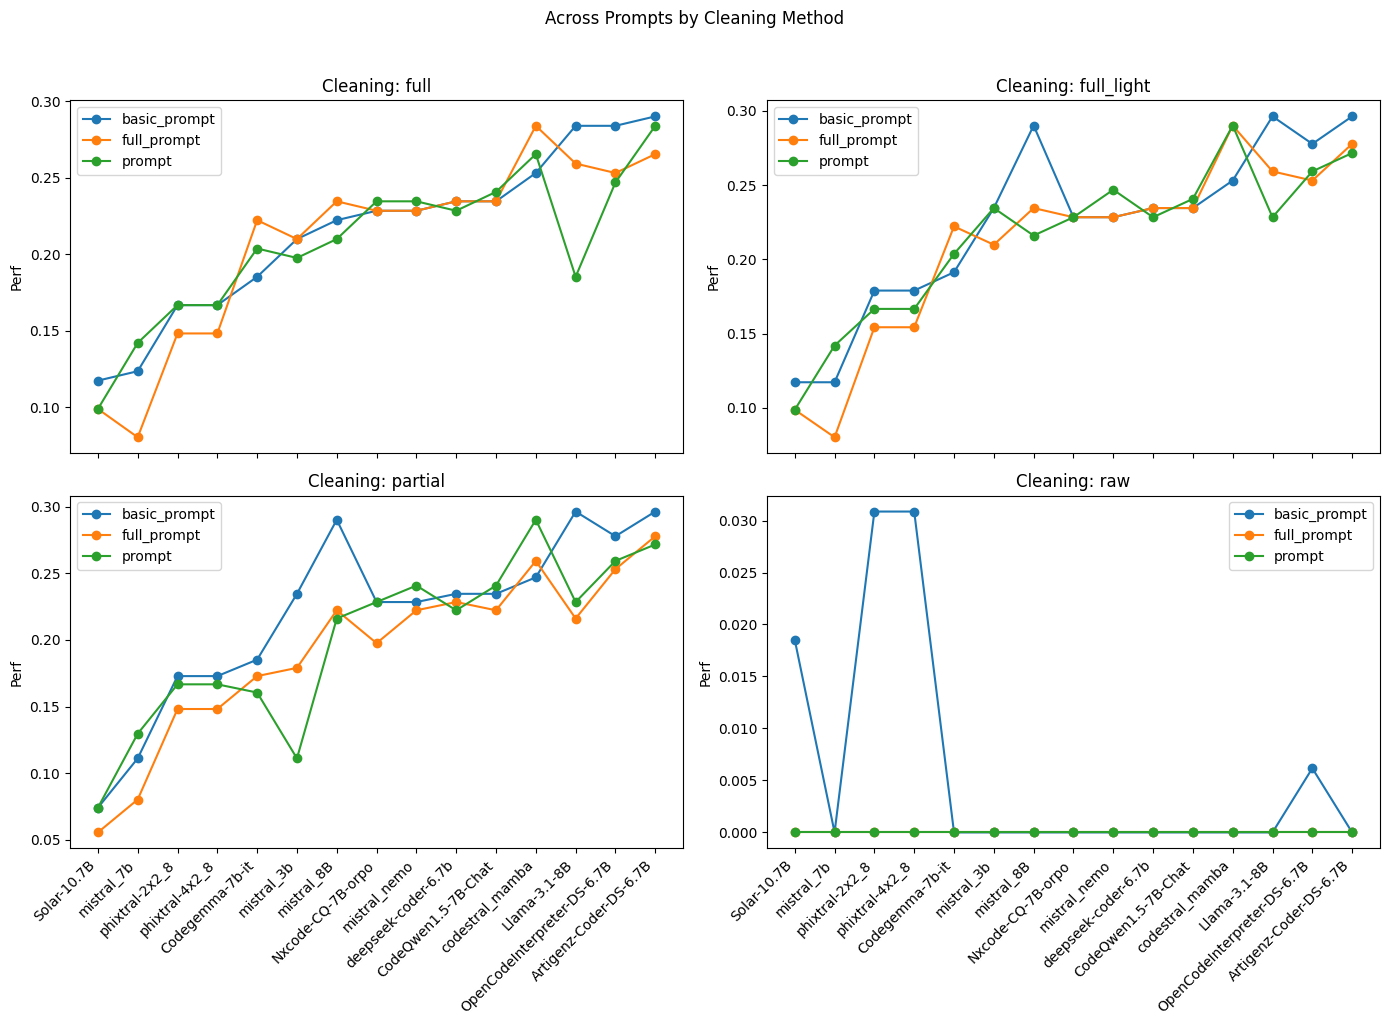

In [25]:
cleanings = df.index.levels[1]
prompts   = df.index.levels[0]

# get the first cleaning ('full') and sort by basic_prompt
first_clean = cleanings[0]
print(first_clean)
y_basic = df.loc[("basic_prompt", first_clean)]               # Series indexed by score_cols
sorted_models = y_basic.sort_values().index.tolist()            # ascending order of basic_prompt

# plot using that same sorted_models order
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

for ax, clean in zip(axes.flatten(), cleanings):
    for prompt in prompts:
        y = df.loc[(prompt, clean), sorted_models]
        ax.plot(range(len(sorted_models)), y, marker='o', label=prompt)
    ax.set_title(f'Cleaning: {clean}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Perf')
    ax.legend()

fig.suptitle('Performance Across Prompts by Cleaning Method', y=1.02)
plt.tight_layout()
plt.show()

basic_prompt


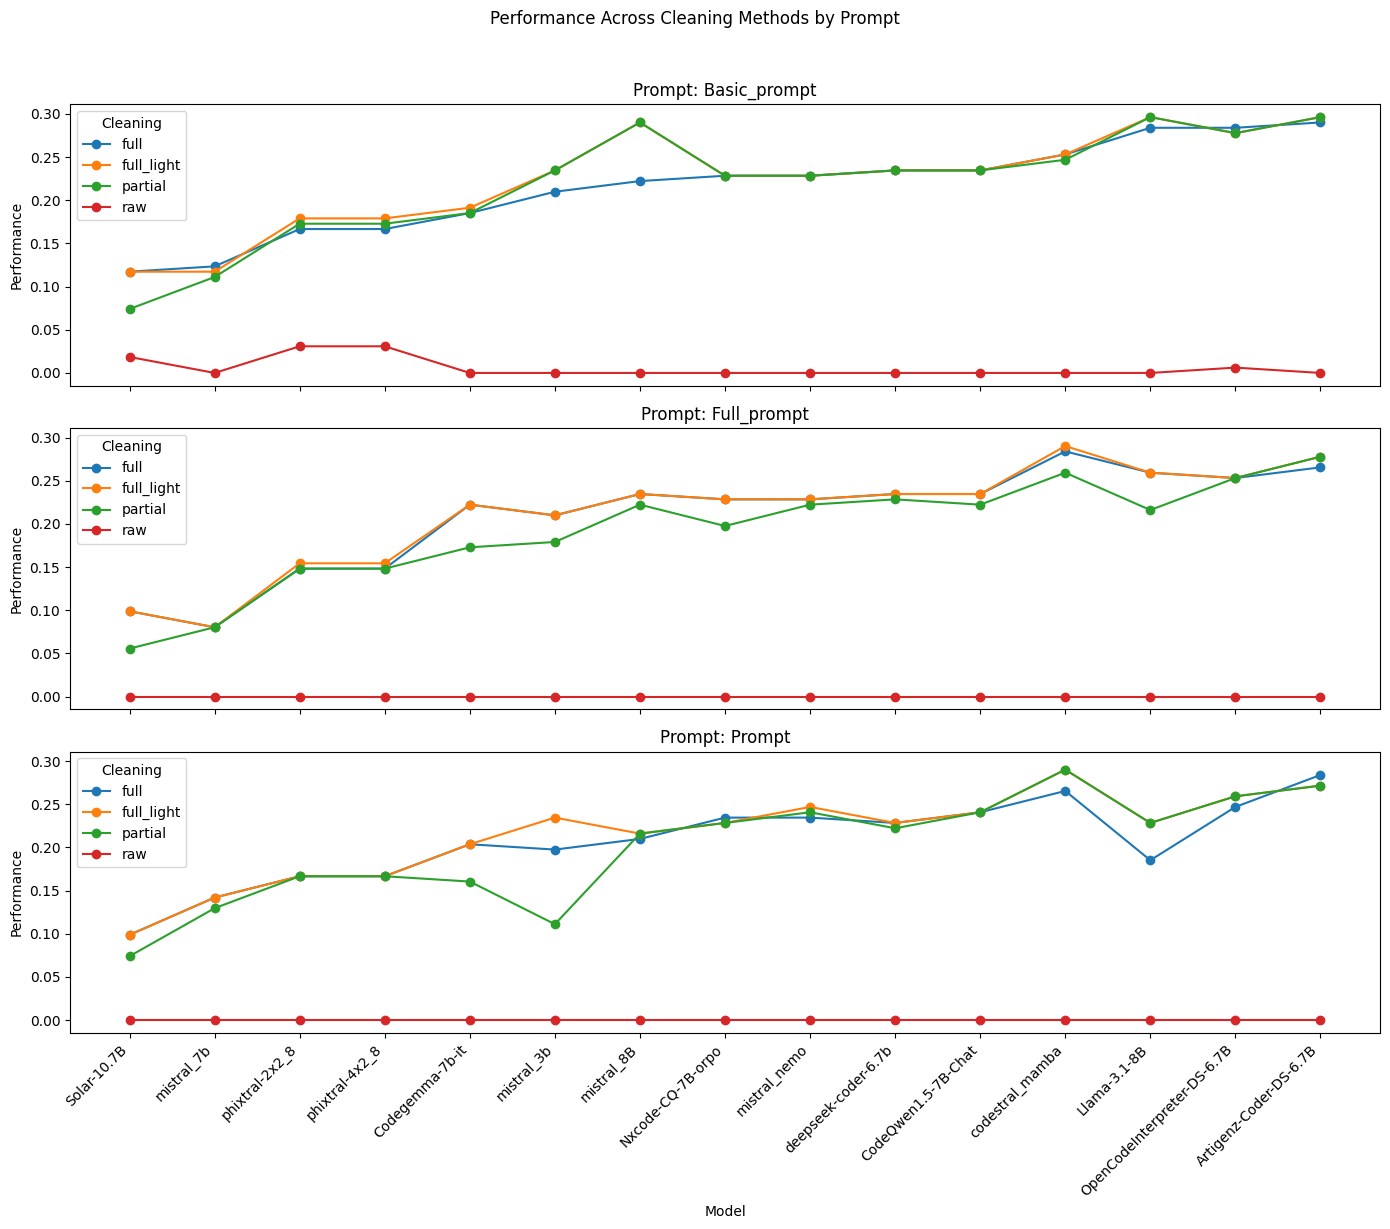

In [32]:
prompts   = df.index.levels[0]
cleanings = df.index.levels[1]

# get the first prompt ('basic_prompt') and sort by 'full' cleaning
first_prompt   = prompts[0]
print(first_prompt)
y_full_clean   = df.loc[(first_prompt, 'full')]                    # Series indexed by model_cols
sorted_models  = y_full_clean.sort_values().index.tolist()         # ascending order

# plot each prompt using that sorted_models on the x-axis
fig, axes = plt.subplots(len(prompts), 1,
                         figsize=(14, 4 * len(prompts)),
                         sharex=True, sharey=True)

for ax, prompt in zip(axes, prompts):
    for clean in cleanings:
        # grab and re-order the y-values by sorted_models
        y = df.loc[(prompt, clean), sorted_models]
        ax.plot(range(len(sorted_models)), y, marker='o', label=clean)

    ax.set_title(f'Prompt: {prompt.capitalize()}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Performance')
    ax.legend(title='Cleaning')

# only label the bottom x-axis
axes[-1].set_xlabel('Model')

fig.suptitle('Performance Across Cleaning Methods by Prompt', y=1.02)
plt.tight_layout()
plt.show()

In [5]:
row_means = df.mean(axis=1)
print(row_means)

prompt        cleaning  
basic_prompt  raw           0.005761
              partial       0.218930
              full          0.215226
              full_light    0.223868
prompt        raw           0.000000
              partial       0.200412
              full          0.206996
              full_light    0.214815
full_prompt   raw           0.000000
              partial       0.192181
              full          0.208642
              full_light    0.210700
dtype: float64


In [6]:
row_max = df.max(axis=1)
print(row_max)

prompt        cleaning  
basic_prompt  raw           0.030864
              partial       0.296296
              full          0.290123
              full_light    0.296296
prompt        raw           0.000000
              partial       0.290123
              full          0.283951
              full_light    0.290123
full_prompt   raw           0.000000
              partial       0.277778
              full          0.283951
              full_light    0.290123
dtype: float64


In [10]:
# compute column‐wise means and maxima
col_means = df.mean(axis=0).sort_values()
col_maxes = df.max(axis=0).sort_values()

# print each Series (index = model names)
print("Column‐wise means:\n", col_means, "\n", sep='')
print("Column‐wise maxima:\n", col_maxes, "\n", sep='')

max_locs = df.idxmax(axis=0)
print("Max locations:\n", max_locs, sep='')

Column‐wise means:
Solar-10.7B                    0.070988
mistral_7b                     0.083848
phixtral-2x2_8                 0.125000
phixtral-4x2_8                 0.125000
Codegemma-7b-it                0.145576
mistral_3b                     0.151749
Nxcode-CQ-7B-orpo              0.169239
deepseek-coder-6.7b            0.173354
mistral_nemo                   0.173868
CodeQwen1.5-7B-Chat            0.176440
mistral_8B                     0.177984
Llama-3.1-8B                   0.187757
OpenCodeInterpreter-DS-6.7B    0.197531
codestral_mamba                0.202675
Artigenz-Coder-DS-6.7B         0.210905
dtype: float64

Column‐wise maxima:
Solar-10.7B                    0.117284
mistral_7b                     0.141975
phixtral-2x2_8                 0.179012
phixtral-4x2_8                 0.179012
Codegemma-7b-it                0.222222
deepseek-coder-6.7b            0.234568
Nxcode-CQ-7B-orpo              0.234568
mistral_3b                     0.234568
CodeQwen1.5-7B-Chat      

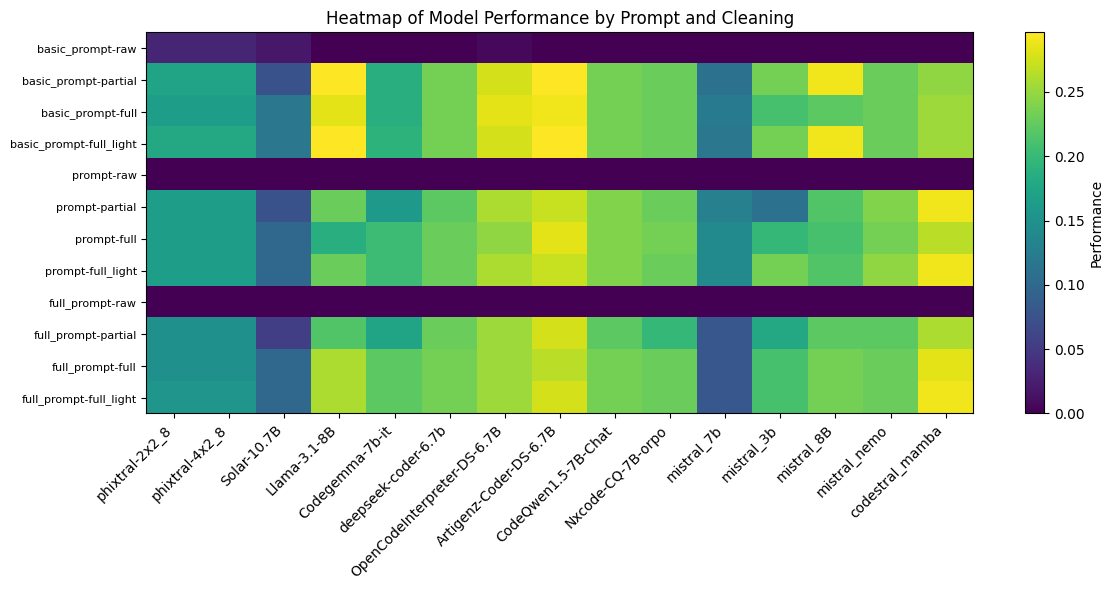

In [38]:
# Heatmap
plt.figure(figsize=(12,6))
plt.imshow(df.values.astype(float), aspect='auto', cmap='viridis')
plt.colorbar(label='Performance')
plt.xticks(range(len(score_cols)), score_cols, rotation=45, ha='right')
plt.yticks(range(len(df.index)), [f"{p}-{c}" for p,c in df.index], fontsize=8)
plt.title('Heatmap of Model Performance by Prompt and Cleaning')
plt.tight_layout()
plt.show()

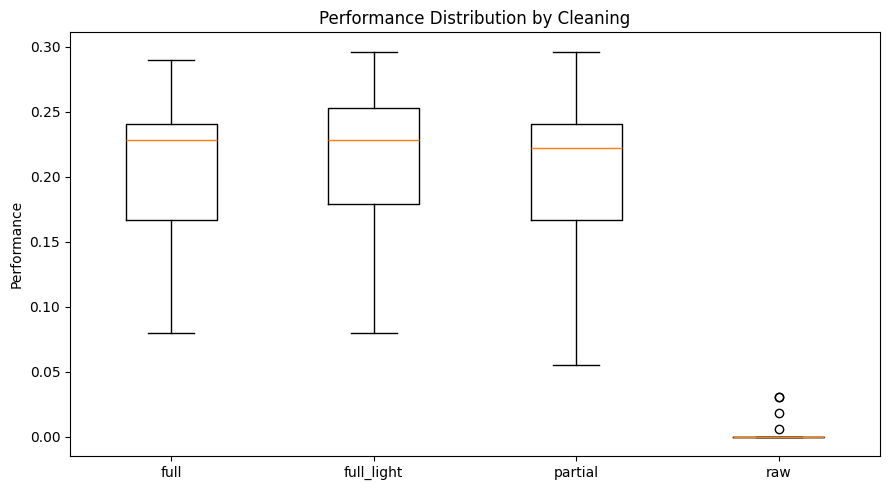

In [36]:
plt.figure(figsize=(9,5))
plt.boxplot([df.xs(c, level='cleaning').values.flatten() for c in cleanings],
            labels=cleanings)
plt.title('Performance Distribution by Cleaning')
plt.ylabel('Performance')
plt.tight_layout()
plt.show()

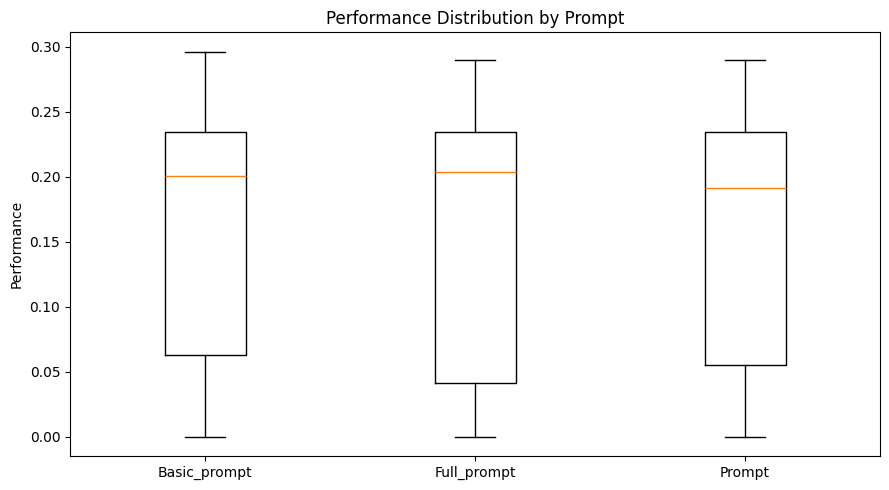

In [37]:
# Boxplots
plt.figure(figsize=(9,5))
plt.boxplot([df.loc[p].values.flatten() for p in prompts],
            labels=[p.capitalize() for p in prompts])
plt.title('Performance Distribution by Prompt')
plt.ylabel('Performance')
plt.tight_layout()
plt.show()

## MBPP

In [46]:
file = '/Users/andrew/Documents/04_git/code-generation/0_documents/2_docs/indiv_model_results_20250322.xlsx'
mbpp = pd.read_excel(file, sheet_name='MBPP')
mbpp

# dataset        prompt    cleaning  temperature  top_p  phixtral-2x2_8  \
0    1    mbpp  basic_prompt         raw            1      1           0.000   
1    2    mbpp  basic_prompt     partial            1      1           0.478   
2    3    mbpp  basic_prompt        full            1      1           0.480   
3    4    mbpp  basic_prompt  full_light            1      1           0.478   
4    5    mbpp        prompt         raw            1      1           0.000   
5    6    mbpp        prompt     partial            1      1           0.498   
6    7    mbpp        prompt        full            1      1           0.498   
7    8    mbpp        prompt  full_light            1      1           0.498   
8    9    mbpp   full_prompt         raw            1      1           0.002   
9   10    mbpp   full_prompt     partial            1      1           0.466   
10  11    mbpp   full_prompt        full            1      1           0.478   
11  12    mbpp   full_prompt  full_light            1      1           0.478   

    phixtral-4x2_8  Solar-10.7B  Llama-3.1-8B  Codegemma-7b-it  \
0            0.000        0.012         0.020            0.000   
1            0.478        0.448         0.598            0.534   
2            0.480        0.448         0.604            0.534   
3            0.478        0.448         0.598            0.534   
4            0.000        0.000         0.000            0.000   
5            0.498        0.430         0.524            0.534   
6            0.498        0.430         0.564            0.534   
7            0.498        0.430         0.564            0.534   
8            0.002        0.000         0.000            0.000   
9            0.466        0.396         0.582            0.528   
10           0.478        0.398         0.608            0.528   
11           0.478        0.398         0.608            0.528   

    deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
0                 0.000                        0.108                   0.006   
1                 0.636                        0.630                   0.648   
2                 0.644                        0.630                   0.648   
3                 0.636                        0.630                   0.648   
4                 0.000                        0.000                   0.000   
5                 0.612                        0.638                   0.610   
6                 0.614                        0.638                   0.610   
7                 0.612                        0.638                   0.610   
8                 0.000                        0.000                   0.000   
9                 0.630                        0.636                   0.618   
10                0.630                        0.636                   0.620   
11                0.630                        0.636                   0.620   

    CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  mistral_3b  \
0                 0.000              0.000       0.000       0.000   
1                 0.734              0.730       0.410       0.554   
2                 0.734              0.730       0.422       0.554   
3                 0.734              0.730       0.410       0.554   
4                 0.000              0.000       0.000       0.000   
5                 0.734              0.740       0.370       0.128   
6                 0.734              0.740       0.370       0.510   
7                 0.734              0.740       0.370       0.510   
8                 0.000              0.000       0.000       0.000   
9                 0.720              0.726       0.366       0.416   
10                0.720              0.726       0.366       0.502   
11                0.720              0.726       0.366       0.502   

    mistral_8B  mistral_nemo  codestral_mamba  
0        0.000         0.000            0.008  
1        0.592         0.560            0.584  
2        

In [47]:
# Identify & select only the 15 SLM model columns
param_cols = ['#', 'dataset', 'prompt', 'cleaning', 'temperature', 'top_p']
score_cols = [c for c in mbpp.columns if c not in param_cols]
mbpp_scores = mbpp[score_cols].apply(pd.to_numeric, errors='coerce')

# Rebuild MultiIndex on rows from the original prompt/cleaning columns
mi = pd.MultiIndex.from_frame(mbpp[['prompt','cleaning']])
mbpp_scores.index = mi
mbpp_scores.index.names = ['prompt','cleaning']
mbpp_scores

phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  \
prompt       cleaning                                                  
basic_prompt raw                  0.000           0.000        0.012   
             partial              0.478           0.478        0.448   
             full                 0.480           0.480        0.448   
             full_light           0.478           0.478        0.448   
prompt       raw                  0.000           0.000        0.000   
             partial              0.498           0.498        0.430   
             full                 0.498           0.498        0.430   
             full_light           0.498           0.498        0.430   
full_prompt  raw                  0.002           0.002        0.000   
             partial              0.466           0.466        0.396   
             full                 0.478           0.478        0.398   
             full_light           0.478           0.478        0.398   

                         Llama-3.1-8B  Codegemma-7b-it  deepseek-coder-6.7b  \
prompt       cleaning                                                         
basic_prompt raw                0.020            0.000                0.000   
             partial            0.598            0.534                0.636   
             full               0.604            0.534                0.644   
             full_light         0.598            0.534                0.636   
prompt       raw                0.000            0.000                0.000   
             partial            0.524            0.534                0.612   
             full               0.564            0.534                0.614   
             full_light         0.564            0.534                0.612   
full_prompt  raw                0.000            0.000                0.000   
             partial            0.582            0.528                0.630   
             full               0.608            0.528                0.630   
             full_light         0.608            0.528                0.630   

                         OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
prompt       cleaning                                                          
basic_prompt raw                               0.108                   0.006   
             partial                           0.630                   0.648   
             full                              0.630                   0.648   
             full_light                        0.630                   0.648   
prompt       raw                               0.000                   0.000   
             partial                           0.638                   0.610   
             full                              0.638                   0.610   
             full_light                        0.638                   0.610   
full_prompt  raw                               0.000                   0.000   
             partial                           0.636                   0.618   
             full                              0.636                   0.620   
             full_light                        0.636                   0.620   

                         CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
prompt       cleaning                                                         
basic_prompt raw                       0.000              0.000       0.000   
             partial                   0.734              0.730       0.410   
             full                      0.734              0.730       0.422   
             full_light                0.734              0.730       0.410   
prompt       raw                       0.000              0.000       0.000   
             partial                   0.734              0.740       0.370   
             full                      0.734              0.740       0.370   
             full_light                0.734              0.740       0.370  

In [48]:
# generic name not to re-write code for each dataset
df = mbpp_scores

full


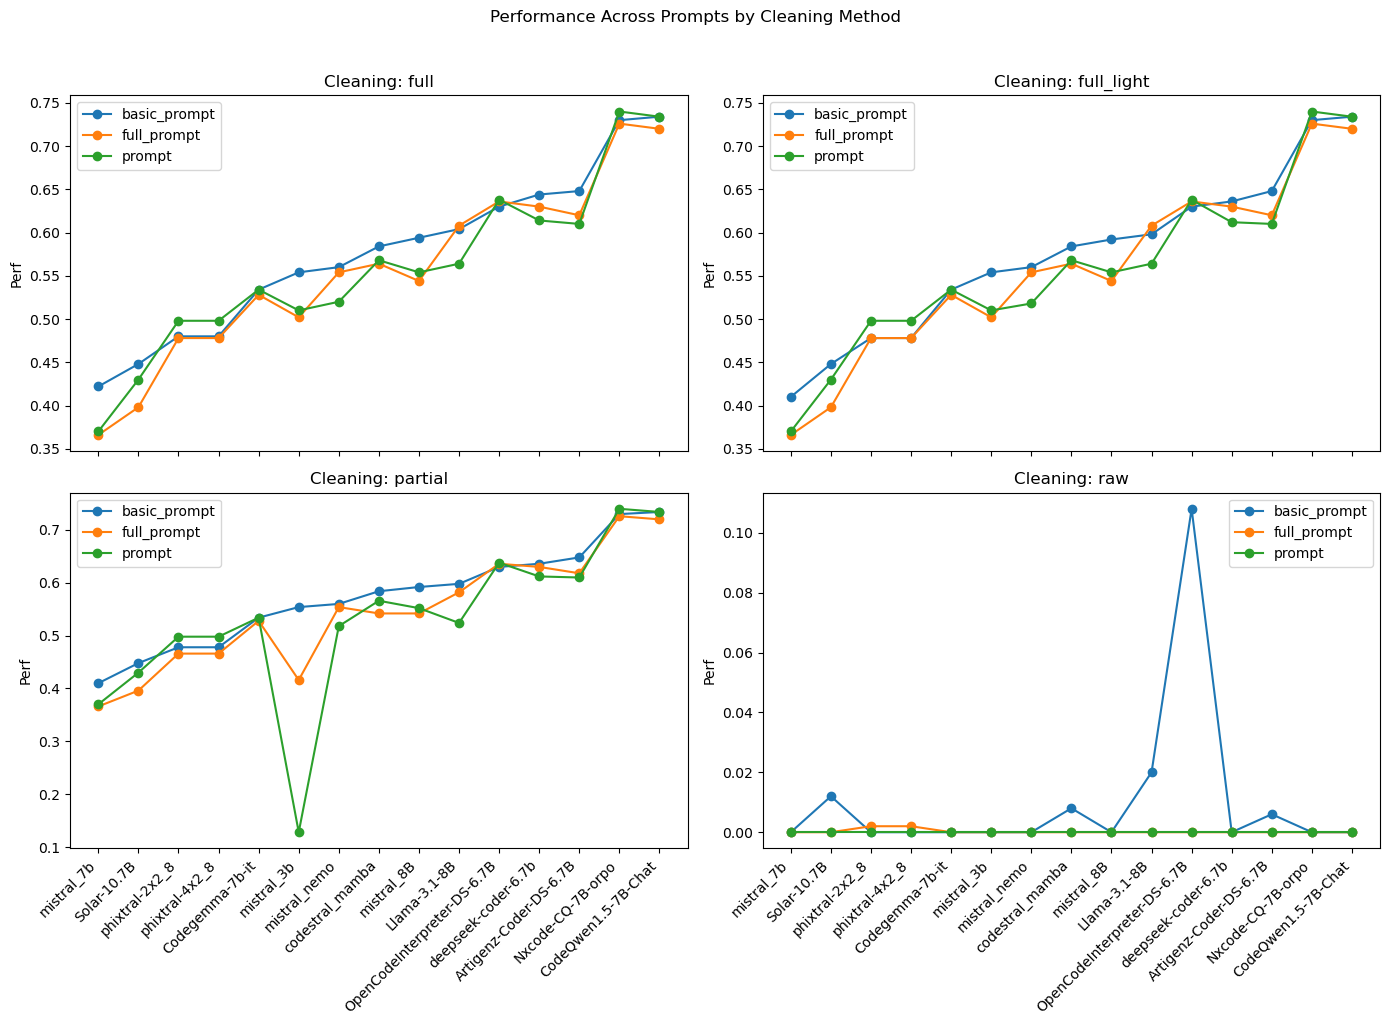

In [49]:
cleanings = df.index.levels[1]
prompts   = df.index.levels[0]

# get the first cleaning ('full') and sort by basic_prompt
first_clean = cleanings[0]
print(first_clean)
y_basic = df.loc[("basic_prompt", first_clean)]               # Series indexed by score_cols
sorted_models = y_basic.sort_values().index.tolist()            # ascending order of basic_prompt

# plot using that same sorted_models order
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

for ax, clean in zip(axes.flatten(), cleanings):
    for prompt in prompts:
        y = df.loc[(prompt, clean), sorted_models]
        ax.plot(range(len(sorted_models)), y, marker='o', label=prompt)
    ax.set_title(f'Cleaning: {clean}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Perf')
    ax.legend()

fig.suptitle('Performance Across Prompts by Cleaning Method', y=1.02)
plt.tight_layout()
plt.show()

basic_prompt


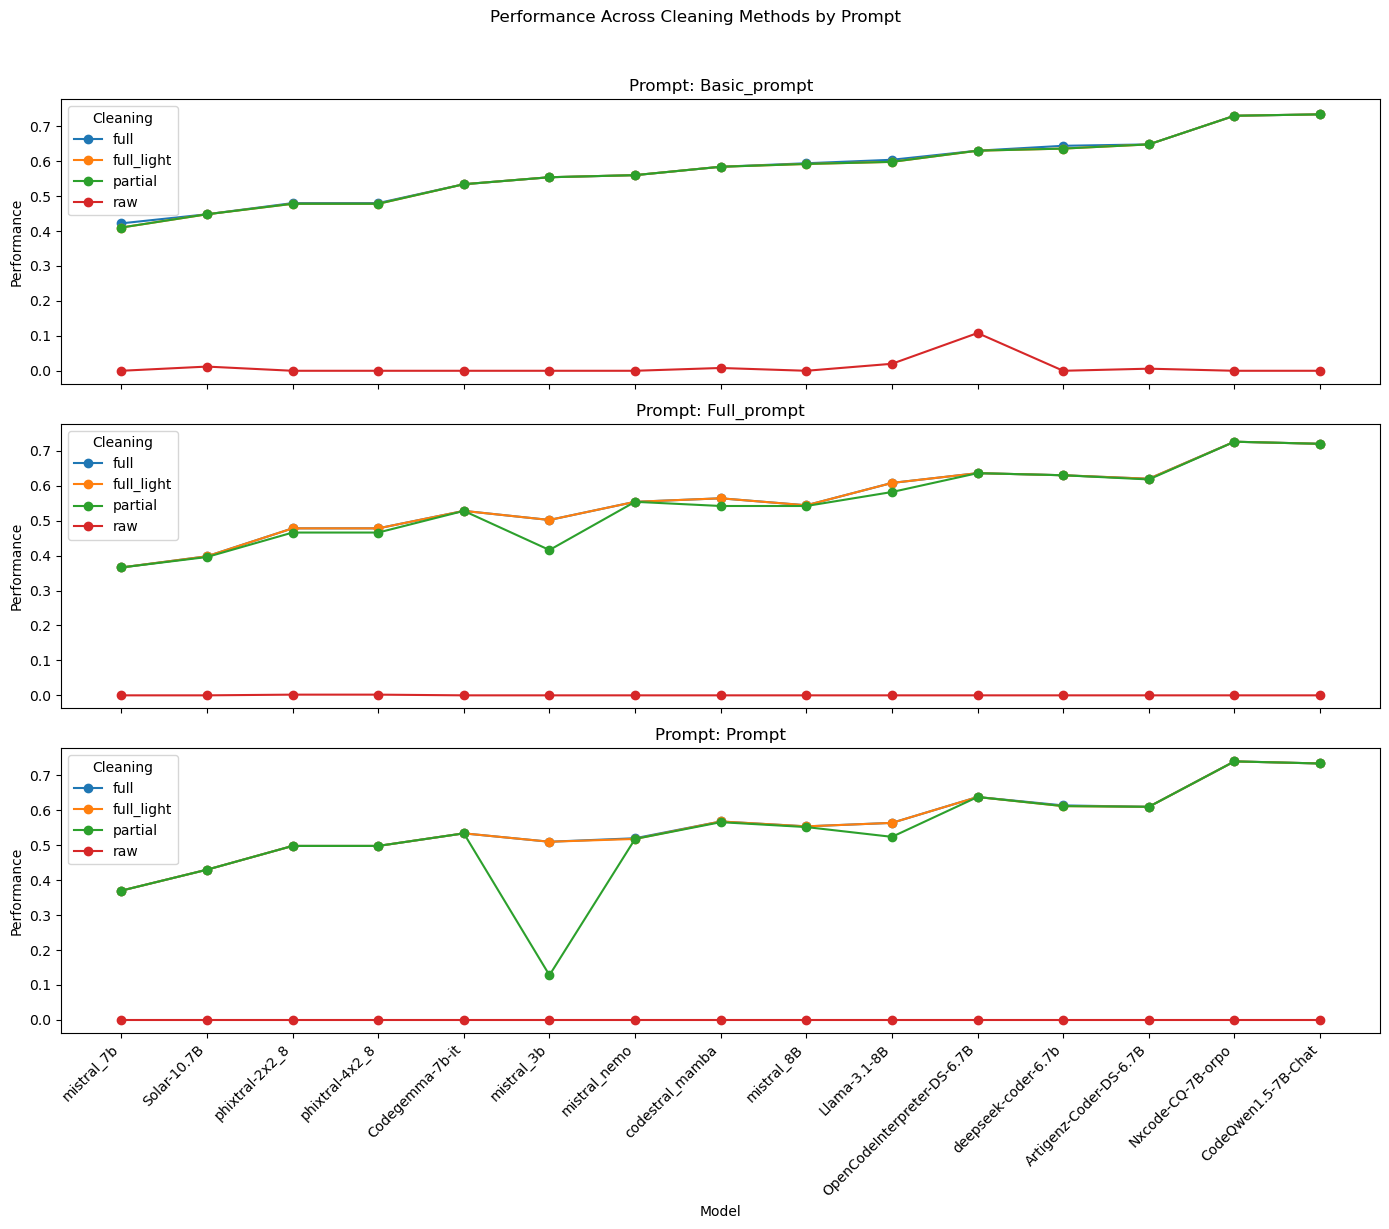

In [50]:
prompts   = df.index.levels[0]
cleanings = df.index.levels[1]

# get the first prompt ('basic_prompt') and sort by 'full' cleaning
first_prompt   = prompts[0]
print(first_prompt)
y_full_clean   = df.loc[(first_prompt, 'full')]                    # Series indexed by model_cols
sorted_models  = y_full_clean.sort_values().index.tolist()         # ascending order

# plot each prompt using that sorted_models on the x-axis
fig, axes = plt.subplots(len(prompts), 1,
                         figsize=(14, 4 * len(prompts)),
                         sharex=True, sharey=True)

for ax, prompt in zip(axes, prompts):
    for clean in cleanings:
        # grab and re-order the y-values by sorted_models
        y = df.loc[(prompt, clean), sorted_models]
        ax.plot(range(len(sorted_models)), y, marker='o', label=clean)

    ax.set_title(f'Prompt: {prompt.capitalize()}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Performance')
    ax.legend(title='Cleaning')

# only label the bottom x-axis
axes[-1].set_xlabel('Model')

fig.suptitle('Performance Across Cleaning Methods by Prompt', y=1.02)
plt.tight_layout()
plt.show()

In [51]:
row_means = df.mean(axis=1)
print(row_means)

prompt        cleaning  
basic_prompt  raw           0.010267
              partial       0.574267
              full          0.576400
              full_light    0.574267
prompt        raw           0.000000
              partial       0.530133
              full          0.558800
              full_light    0.558533
full_prompt   raw           0.000267
              partial       0.545867
              full          0.556800
              full_light    0.556800
dtype: float64


In [52]:
row_max = df.max(axis=1)
print(row_max)

prompt        cleaning  
basic_prompt  raw           0.108
              partial       0.734
              full          0.734
              full_light    0.734
prompt        raw           0.000
              partial       0.740
              full          0.740
              full_light    0.740
full_prompt   raw           0.002
              partial       0.726
              full          0.726
              full_light    0.726
dtype: float64


In [53]:
# compute column‐wise means and maxima
col_means = df.mean(axis=0).sort_values()
col_maxes = df.max(axis=0).sort_values()

# print each Series (index = model names)
print("Column‐wise means:\n", col_means, "\n", sep='')
print("Column‐wise maxima:\n", col_maxes, "\n", sep='')

max_locs = df.idxmax(axis=0)
print("Max locations:\n", max_locs, sep='')

Column‐wise means:
mistral_7b                     0.287500
Solar-10.7B                    0.319833
mistral_3b                     0.352500
phixtral-2x2_8                 0.362833
phixtral-4x2_8                 0.362833
Codegemma-7b-it                0.399000
mistral_nemo                   0.408167
mistral_8B                     0.422333
codestral_mamba                0.427667
Llama-3.1-8B                   0.439167
Artigenz-Coder-DS-6.7B         0.469833
deepseek-coder-6.7b            0.470333
OpenCodeInterpreter-DS-6.7B    0.485000
CodeQwen1.5-7B-Chat            0.547000
Nxcode-CQ-7B-orpo              0.549000
dtype: float64

Column‐wise maxima:
mistral_7b                     0.422
Solar-10.7B                    0.448
phixtral-2x2_8                 0.498
phixtral-4x2_8                 0.498
Codegemma-7b-it                0.534
mistral_3b                     0.554
mistral_nemo                   0.560
codestral_mamba                0.584
mistral_8B                     0.594
Llama-3.1-8B

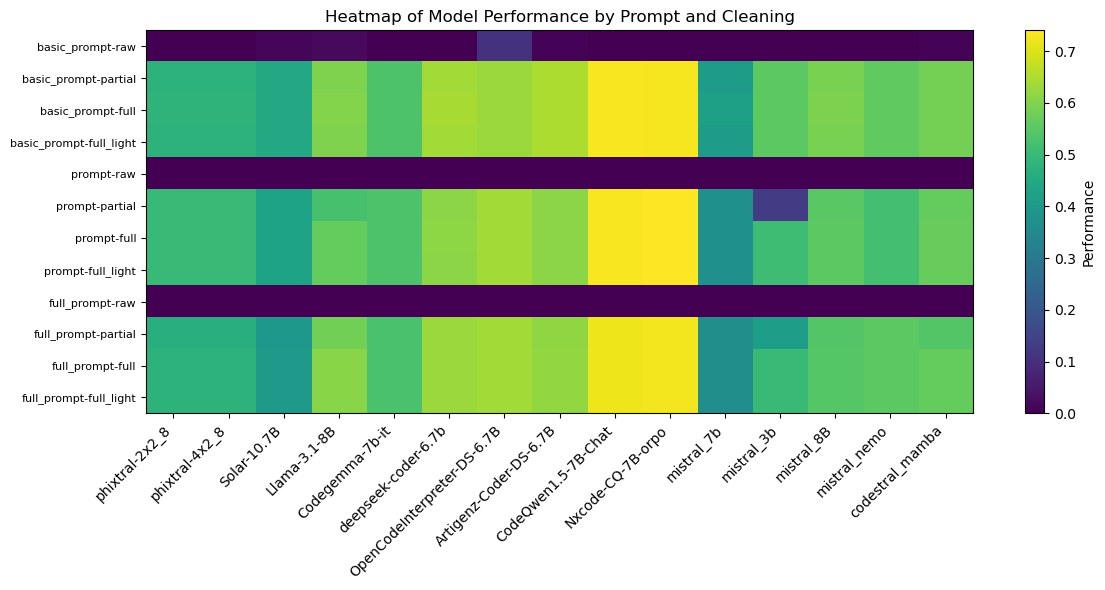

In [54]:
# Heatmap
plt.figure(figsize=(12,6))
plt.imshow(df.values.astype(float), aspect='auto', cmap='viridis')
plt.colorbar(label='Performance')
plt.xticks(range(len(score_cols)), score_cols, rotation=45, ha='right')
plt.yticks(range(len(df.index)), [f"{p}-{c}" for p,c in df.index], fontsize=8)
plt.title('Heatmap of Model Performance by Prompt and Cleaning')
plt.tight_layout()
plt.show()

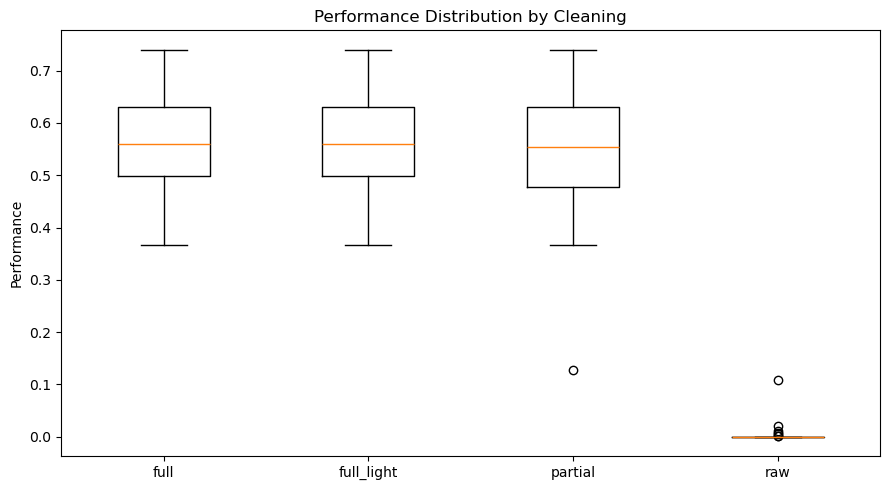

In [55]:
plt.figure(figsize=(9,5))
plt.boxplot([df.xs(c, level='cleaning').values.flatten() for c in cleanings],
            labels=cleanings)
plt.title('Performance Distribution by Cleaning')
plt.ylabel('Performance')
plt.tight_layout()
plt.show()

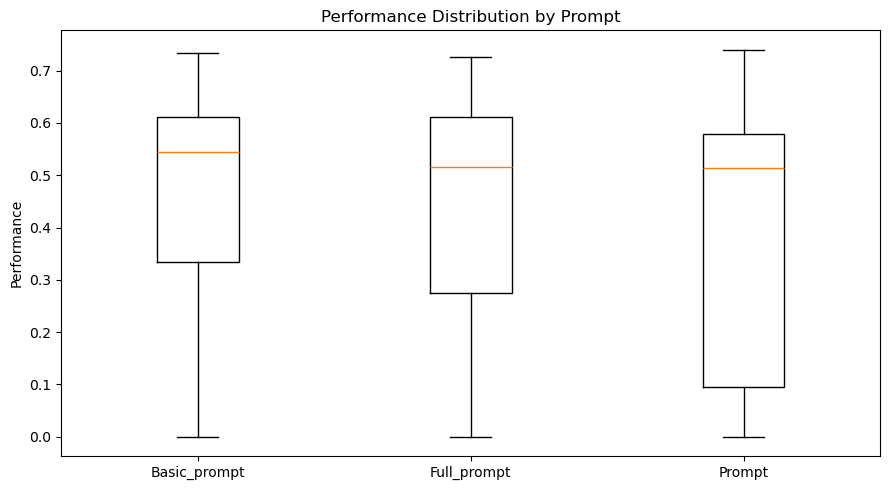

In [56]:
# Boxplots
plt.figure(figsize=(9,5))
plt.boxplot([df.loc[p].values.flatten() for p in prompts],
            labels=[p.capitalize() for p in prompts])
plt.title('Performance Distribution by Prompt')
plt.ylabel('Performance')
plt.tight_layout()
plt.show()

____

## LBPP Reflection

In [113]:
file = '/Users/andrew/Documents/04_git/code-generation/0_documents/2_docs/indiv_model_results_20250322.xlsx'
lbpp_reflection = pd.read_excel(file, sheet_name='LBPP_Reflection')
lbpp_reflection

# dataset        prompt    cleaning  temperature  top_p  phixtral-2x2_8  \
0    1    lbpp  basic_prompt         raw            1      1        0.018519   
1    2    lbpp  basic_prompt     partial            1      1        0.141975   
2    3    lbpp  basic_prompt        full            1      1        0.141975   
3    4    lbpp  basic_prompt  full_light            1      1        0.148148   
4    5    lbpp        prompt         raw            1      1        0.000000   
5    6    lbpp        prompt     partial            1      1        0.185185   
6    7    lbpp        prompt        full            1      1        0.179012   
7    8    lbpp        prompt  full_light            1      1        0.185185   
8    9    lbpp   full_prompt         raw            1      1        0.000000   
9   10    lbpp   full_prompt     partial            1      1        0.148148   
10  11    lbpp   full_prompt        full            1      1        0.154321   
11  12    lbpp   full_prompt  full_light            1      1        0.160494   

    Llama-3.1-8B  Codegemma-7b-it  deepseek-coder-6.7b  \
0       0.000000         0.000000             0.000000   
1       0.259259         0.172840             0.259259   
2       0.246914         0.166667             0.259259   
3       0.259259         0.179012             0.259259   
4       0.000000         0.000000             0.000000   
5       0.271605         0.123457             0.228395   
6       0.234568         0.135802             0.228395   
7       0.283951         0.154321             0.234568   
8       0.000000         0.000000             0.000000   
9       0.240741         0.166667             0.216049   
10      0.240741         0.203704             0.222222   
11      0.240741         0.203704             0.222222   

    OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  \
0                      0.006173                0.000000             0.000000   
1                      0.290123                0.290123             0.228395   
2                      0.290123                0.283951             0.228395   
3                      0.290123                0.290123             0.228395   
4                      0.000000                0.000000             0.000000   
5                      0.271605                0.265432             0.240741   
6                      0.265432                0.265432             0.240741   
7                      0.271605                0.265432             0.240741   
8                      0.000000                0.000000             0.000000   
9                      0.253086                0.271605             0.228395   
10                     0.253086                0.271605             0.246914   
11                     0.253086                0.277778             0.246914   

    Nxcode-CQ-7B-orpo  mistral_3b  mistral_8B  mistral_nemo  
0            0.000000    0.000000    0.000000      0.000000  
1            0.228395    0.271605    0.302469      0.259259  
2            0.228395    0.222222    0.240741      0.253086  
3            0.228395    0.271605    0.302469      0.259259  
4            0.000000    0.000000    0.000000      0.000000  
5            0.234568    0.092593    0.222222      0.234568  
6            0.234568    0.166667    0.222222      0.228395  
7            0.234568    0.228395    0.228395      0.240741  
8            0.000000    0.000000    0.000000      0.000000  
9            0.197531    0.160494    0.228395      0.228395  
10           0.234568    0.197531    0.240741      0.228395  
11           0.234568    0.197531    0.240741      0.228395

In [114]:
# Identify & select only the 15 SLM model columns
param_cols = ['#', 'dataset', 'prompt', 'cleaning', 'temperature', 'top_p']
score_cols = [c for c in lbpp_reflection.columns if c not in param_cols]
lbpp_reflection_scores = lbpp_reflection[score_cols].apply(pd.to_numeric, errors='coerce')

# Rebuild MultiIndex on rows from the original prompt/cleaning columns
mi = pd.MultiIndex.from_frame(lbpp_reflection[['prompt','cleaning']])
lbpp_reflection_scores.index = mi
lbpp_reflection_scores.index.names = ['prompt','cleaning']
lbpp_reflection_scores

phixtral-2x2_8  Llama-3.1-8B  Codegemma-7b-it  \
prompt       cleaning                                                    
basic_prompt raw               0.018519      0.000000         0.000000   
             partial           0.141975      0.259259         0.172840   
             full              0.141975      0.246914         0.166667   
             full_light        0.148148      0.259259         0.179012   
prompt       raw               0.000000      0.000000         0.000000   
             partial           0.185185      0.271605         0.123457   
             full              0.179012      0.234568         0.135802   
             full_light        0.185185      0.283951         0.154321   
full_prompt  raw               0.000000      0.000000         0.000000   
             partial           0.148148      0.240741         0.166667   
             full              0.154321      0.240741         0.203704   
             full_light        0.160494      0.240741         0.203704   

                         deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  \
prompt       cleaning                                                       
basic_prompt raw                    0.000000                     0.006173   
             partial                0.259259                     0.290123   
             full                   0.259259                     0.290123   
             full_light             0.259259                     0.290123   
prompt       raw                    0.000000                     0.000000   
             partial                0.228395                     0.271605   
             full                   0.228395                     0.265432   
             full_light             0.234568                     0.271605   
full_prompt  raw                    0.000000                     0.000000   
             partial                0.216049                     0.253086   
             full                   0.222222                     0.253086   
             full_light             0.222222                     0.253086   

                         Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  \
prompt       cleaning                                                  
basic_prompt raw                       0.000000             0.000000   
             partial                   0.290123             0.228395   
             full                      0.283951             0.228395   
             full_light                0.290123             0.228395   
prompt       raw                       0.000000             0.000000   
             partial                   0.265432             0.240741   
             full                      0.265432             0.240741   
             full_light                0.265432             0.240741   
full_prompt  raw                       0.000000             0.000000   
             partial                   0.271605             0.228395   
             full                      0.271605             0.246914   
             full_light                0.277778             0.246914   

                         Nxcode-CQ-7B-orpo  mistral_3b  mistral_8B  \
prompt       cleaning                                                
basic_prompt raw                  0.000000    0.000000    0.000000   
             partial              0.228395    0.271605    0.302469   
             full                 0.228395    0.222222    0.240741   
             full_light           0.228395    0.271605    0.302469   
prompt       raw                  0.000000    0.000000    0.000000   
             partial              0.234568    0.092593    0.222222   
             full                 0.234568    0.166667    0.222222   
             full_light           0.234568    0.228395    0.228395   
full_prompt  raw                  0.000000    0.000000    0.000000   
             partial              0.197531    0.160494    0.228395   
             full                 0.234568    0.197531    0.

In [115]:
# generic name not to re-write code for each dataset
df = lbpp_reflection_scores

full


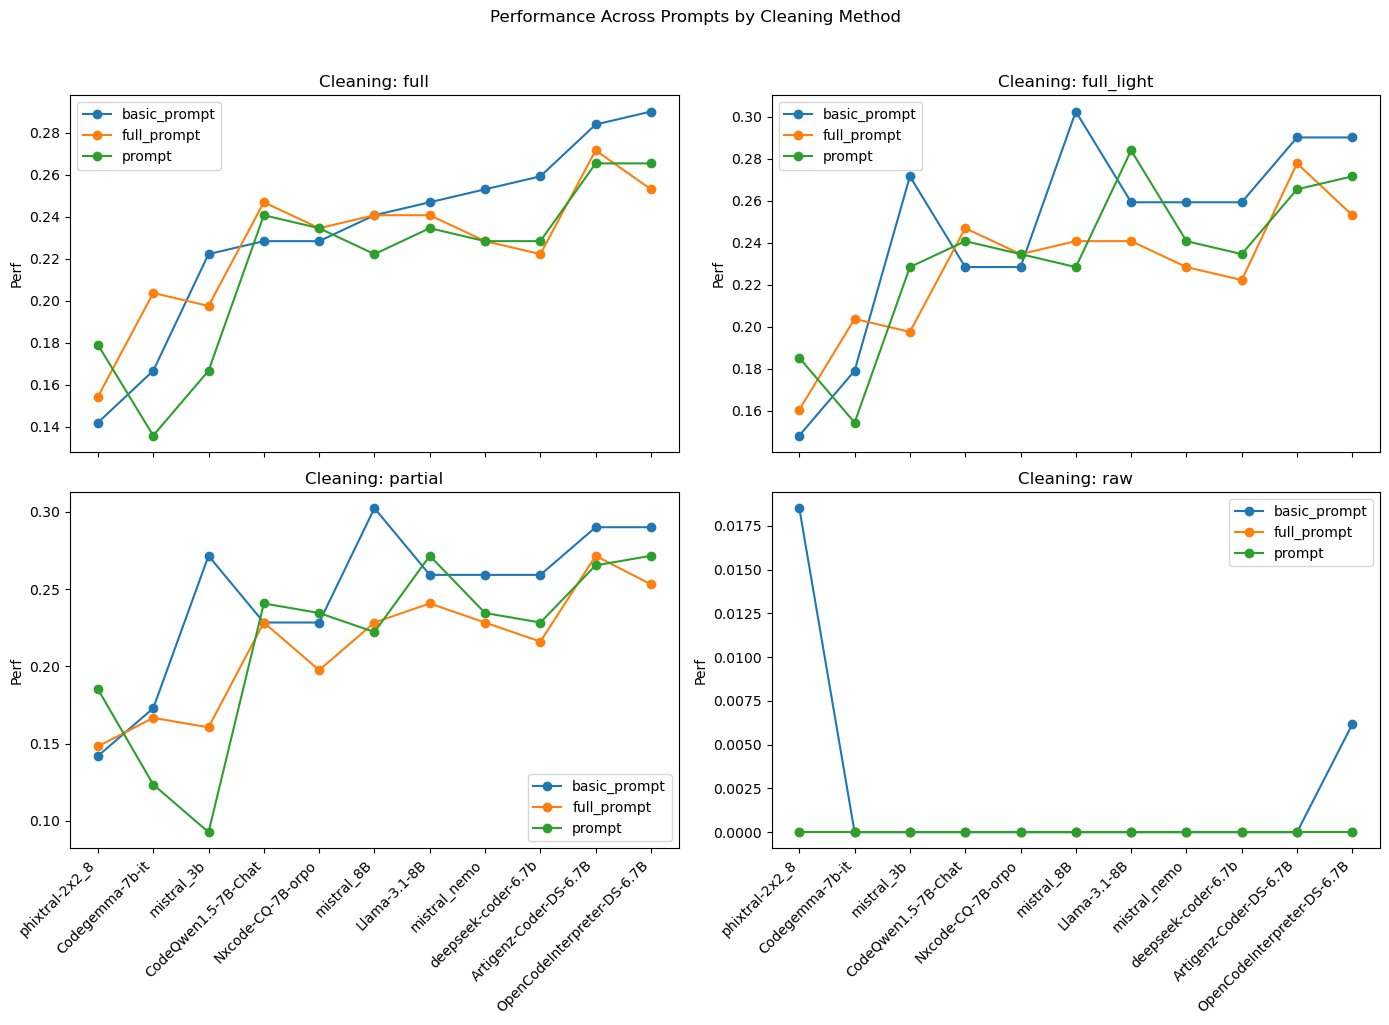

In [116]:
cleanings = df.index.levels[1]
prompts   = df.index.levels[0]

# get the first cleaning ('full') and sort by basic_prompt
first_clean = cleanings[0]
print(first_clean)
y_basic = df.loc[("basic_prompt", first_clean)]               # Series indexed by score_cols
sorted_models = y_basic.sort_values().index.tolist()            # ascending order of basic_prompt

# plot using that same sorted_models order
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

for ax, clean in zip(axes.flatten(), cleanings):
    for prompt in prompts:
        y = df.loc[(prompt, clean), sorted_models]
        ax.plot(range(len(sorted_models)), y, marker='o', label=prompt)
    ax.set_title(f'Cleaning: {clean}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Perf')
    ax.legend()

fig.suptitle('Performance Across Prompts by Cleaning Method', y=1.02)
plt.tight_layout()
plt.show()

basic_prompt


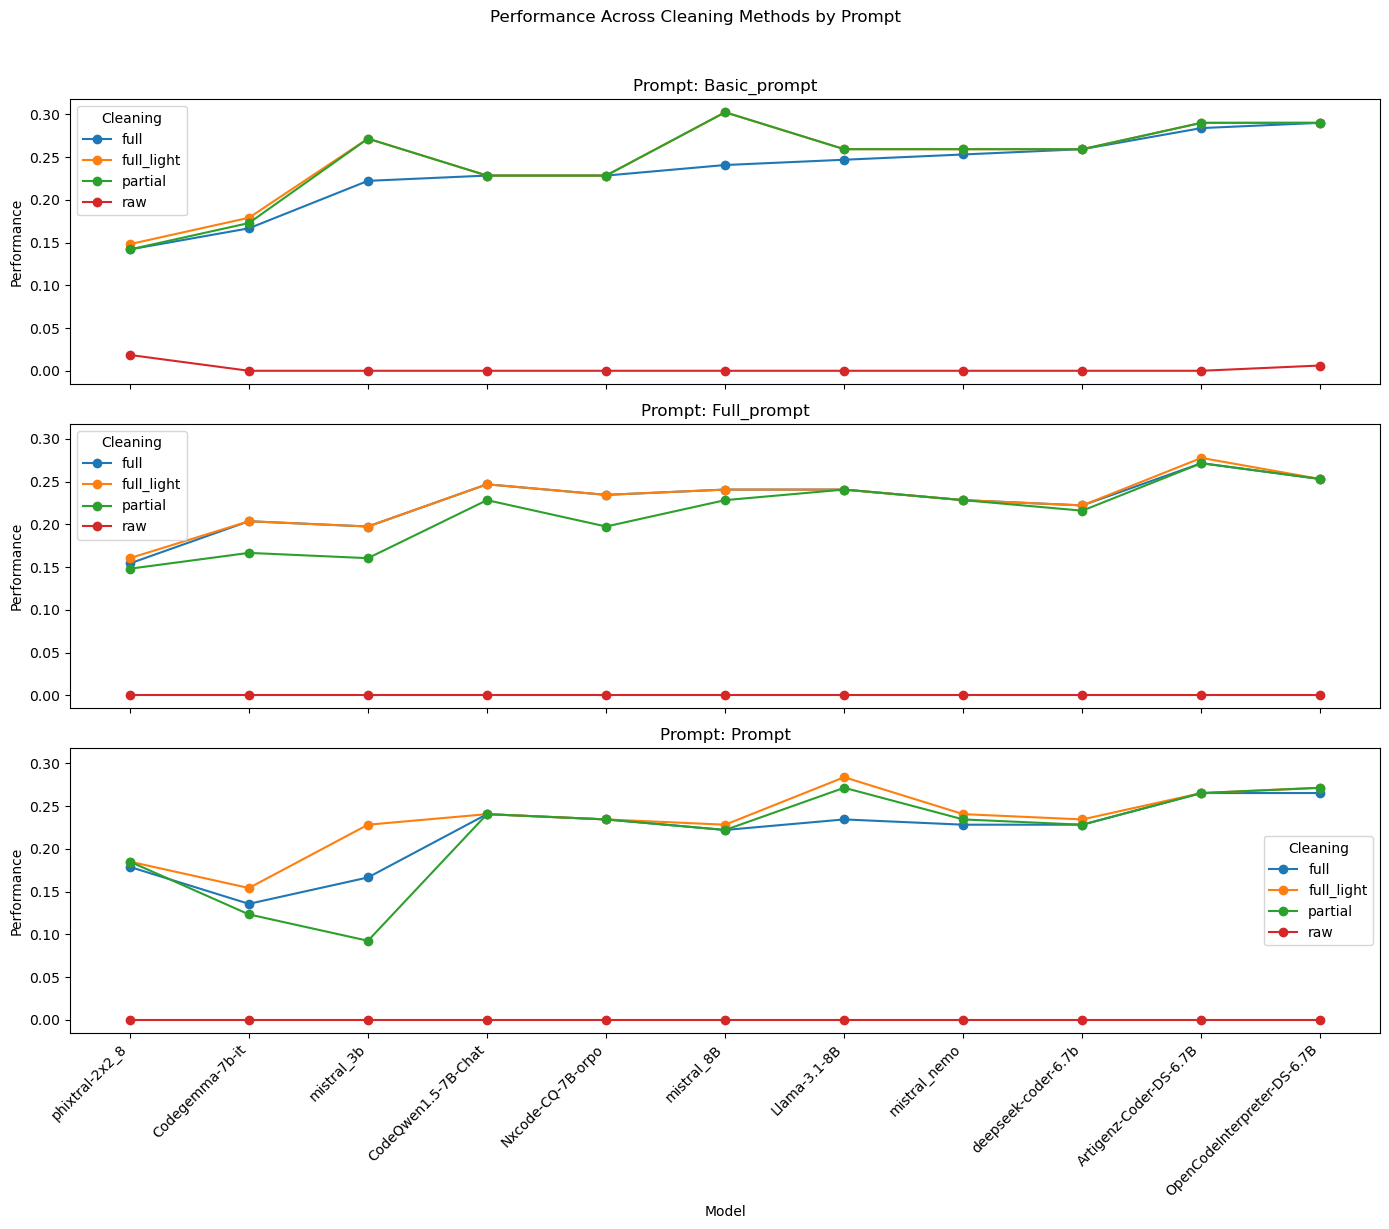

In [117]:
prompts   = df.index.levels[0]
cleanings = df.index.levels[1]

# get the first prompt ('basic_prompt') and sort by 'full' cleaning
first_prompt   = prompts[0]
print(first_prompt)
y_full_clean   = df.loc[(first_prompt, 'full')]                    # Series indexed by model_cols
sorted_models  = y_full_clean.sort_values().index.tolist()         # ascending order

# plot each prompt using that sorted_models on the x-axis
fig, axes = plt.subplots(len(prompts), 1,
                         figsize=(14, 4 * len(prompts)),
                         sharex=True, sharey=True)

for ax, prompt in zip(axes, prompts):
    for clean in cleanings:
        # grab and re-order the y-values by sorted_models
        y = df.loc[(prompt, clean), sorted_models]
        ax.plot(range(len(sorted_models)), y, marker='o', label=clean)

    ax.set_title(f'Prompt: {prompt.capitalize()}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Performance')
    ax.legend(title='Cleaning')

# only label the bottom x-axis
axes[-1].set_xlabel('Model')

fig.suptitle('Performance Across Cleaning Methods by Prompt', y=1.02)
plt.tight_layout()
plt.show()

In [118]:
row_means = df.mean(axis=1)
print(row_means)

prompt        cleaning  
basic_prompt  raw           0.002245
              partial       0.245791
              full          0.232884
              full_light    0.246914
prompt        raw           0.000000
              partial       0.215488
              full          0.218294
              full_light    0.233446
full_prompt   raw           0.000000
              partial       0.212682
              full          0.226712
              full_light    0.227834
dtype: float64


In [119]:
row_max = df.max(axis=1)
print(row_max)

prompt        cleaning  
basic_prompt  raw           0.018519
              partial       0.302469
              full          0.290123
              full_light    0.302469
prompt        raw           0.000000
              partial       0.271605
              full          0.265432
              full_light    0.283951
full_prompt   raw           0.000000
              partial       0.271605
              full          0.271605
              full_light    0.277778
dtype: float64


In [120]:
# compute column‐wise means and maxima
col_means = df.mean(axis=0).sort_values()
col_maxes = df.max(axis=0).sort_values()

# print each Series (index = model names)
print("Column‐wise means:\n", col_means, "\n", sep='')
print("Column‐wise maxima:\n", col_maxes, "\n", sep='')

max_locs = df.idxmax(axis=0)
print("Max locations:\n", max_locs, sep='')

Column‐wise means:
phixtral-2x2_8                 0.121914
Codegemma-7b-it                0.125514
mistral_3b                     0.150720
Nxcode-CQ-7B-orpo              0.171296
CodeQwen1.5-7B-Chat            0.177469
deepseek-coder-6.7b            0.177469
mistral_nemo                   0.180041
mistral_8B                     0.185700
Llama-3.1-8B                   0.189815
OpenCodeInterpreter-DS-6.7B    0.203704
Artigenz-Coder-DS-6.7B         0.206790
dtype: float64

Column‐wise maxima:
phixtral-2x2_8                 0.185185
Codegemma-7b-it                0.203704
Nxcode-CQ-7B-orpo              0.234568
CodeQwen1.5-7B-Chat            0.246914
deepseek-coder-6.7b            0.259259
mistral_nemo                   0.259259
mistral_3b                     0.271605
Llama-3.1-8B                   0.283951
OpenCodeInterpreter-DS-6.7B    0.290123
Artigenz-Coder-DS-6.7B         0.290123
mistral_8B                     0.302469
dtype: float64

Max locations:
phixtral-2x2_8                    

In [ ]:
# many results are better for reflection
# REFLECTION
prompt        cleaning  
basic_prompt  raw           0.002245
              partial       0.245791
              full          0.232884
              full_light    0.246914
prompt        raw           0.000000
              partial       0.215488
              full          0.218294
              full_light    0.233446
full_prompt   raw           0.000000
              partial       0.212682
              full          0.226712
              full_light    0.227834
            
# NON-REFLECTION
prompt        cleaning  
basic_prompt  raw           0.005761
              partial       0.218930
              full          0.215226
              full_light    0.223868
prompt        raw           0.000000
              partial       0.200412
              full          0.206996
              full_light    0.214815
full_prompt   raw           0.000000
              partial       0.192181
              full          0.208642
              full_light    0.210700


# REFLECTION
prompt        cleaning  
basic_prompt  raw           0.018519
              partial       0.302469
              full          0.290123
              full_light    0.302469
prompt        raw           0.000000
              partial       0.271605
              full          0.265432
              full_light    0.283951
full_prompt   raw           0.000000
              partial       0.271605
              full          0.271605
              full_light    0.277778
            
# NON-REFLECTION
prompt        cleaning  
basic_prompt  raw           0.030864
              partial       0.296296
              full          0.290123
              full_light    0.296296
prompt        raw           0.000000
              partial       0.290123
              full          0.283951
              full_light    0.290123
full_prompt   raw           0.000000
              partial       0.277778
              full          0.283951
              full_light    0.290123

# REFLECTION Column‐wise means:
phixtral-2x2_8                 0.121914
Codegemma-7b-it                0.125514
mistral_3b                     0.150720
Nxcode-CQ-7B-orpo              0.171296
CodeQwen1.5-7B-Chat            0.177469
deepseek-coder-6.7b            0.177469
mistral_nemo                   0.180041
mistral_8B                     0.185700
Llama-3.1-8B                   0.189815
OpenCodeInterpreter-DS-6.7B    0.203704
Artigenz-Coder-DS-6.7B         0.206790
            
# NON-REFLECTION
Column‐wise means:
mistral_7b                     0.083848
phixtral-2x2_8                 0.125000
Codegemma-7b-it                0.145576
mistral_3b                     0.151749
Nxcode-CQ-7B-orpo              0.169239
deepseek-coder-6.7b            0.173354
mistral_nemo                   0.173868
CodeQwen1.5-7B-Chat            0.176440
mistral_8B                     0.177984
Llama-3.1-8B                   0.187757
OpenCodeInterpreter-DS-6.7B    0.197531
Artigenz-Coder-DS-6.7B         0.210905
dtype: float64

    
# REFLECTION
phixtral-2x2_8                 0.185185
Codegemma-7b-it                0.203704
Nxcode-CQ-7B-orpo              0.234568
CodeQwen1.5-7B-Chat            0.246914
deepseek-coder-6.7b            0.259259
mistral_nemo                   0.259259
mistral_3b                     0.271605
Llama-3.1-8B                   0.283951
OpenCodeInterpreter-DS-6.7B    0.290123
Artigenz-Coder-DS-6.7B         0.290123
mistral_8B                     0.302469

# NON-REFLECTION
Column‐wise maxima:
phixtral-2x2_8                 0.179012
Codegemma-7b-it                0.222222
deepseek-coder-6.7b            0.234568
Nxcode-CQ-7B-orpo              0.234568
mistral_3b                     0.234568
CodeQwen1.5-7B-Chat            0.240741
mistral_nemo                   0.246914
OpenCodeInterpreter-DS-6.7B    0.283951
mistral_8B                     0.290123
Llama-3.1-8B                   0.296296
Artigenz-Coder-DS-6.7B         0.296296
dtype: float64

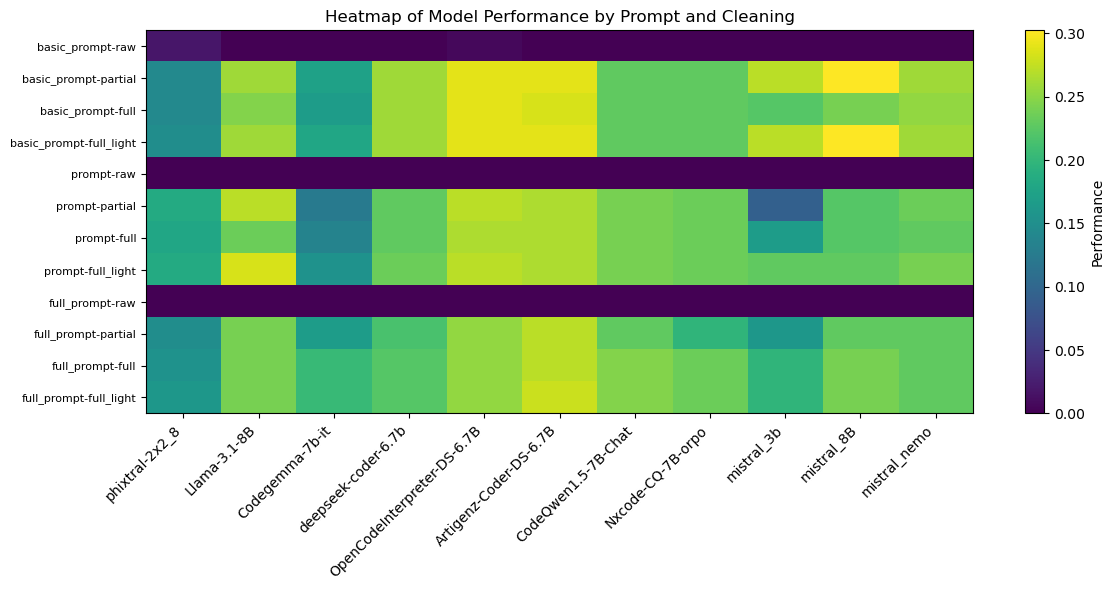

In [121]:
# Heatmap
plt.figure(figsize=(12,6))
plt.imshow(df.values.astype(float), aspect='auto', cmap='viridis')
plt.colorbar(label='Performance')
plt.xticks(range(len(score_cols)), score_cols, rotation=45, ha='right')
plt.yticks(range(len(df.index)), [f"{p}-{c}" for p,c in df.index], fontsize=8)
plt.title('Heatmap of Model Performance by Prompt and Cleaning')
plt.tight_layout()
plt.show()

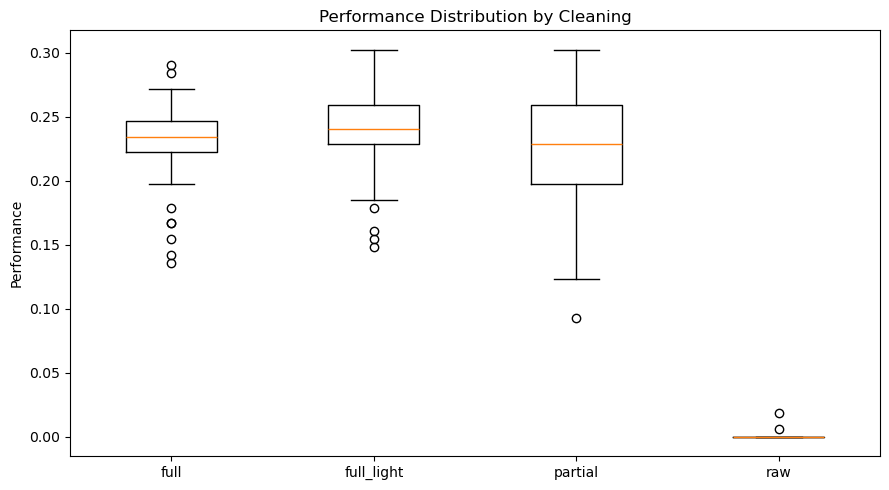

In [122]:
plt.figure(figsize=(9,5))
plt.boxplot([df.xs(c, level='cleaning').values.flatten() for c in cleanings],
            labels=cleanings)
plt.title('Performance Distribution by Cleaning')
plt.ylabel('Performance')
plt.tight_layout()
plt.show()

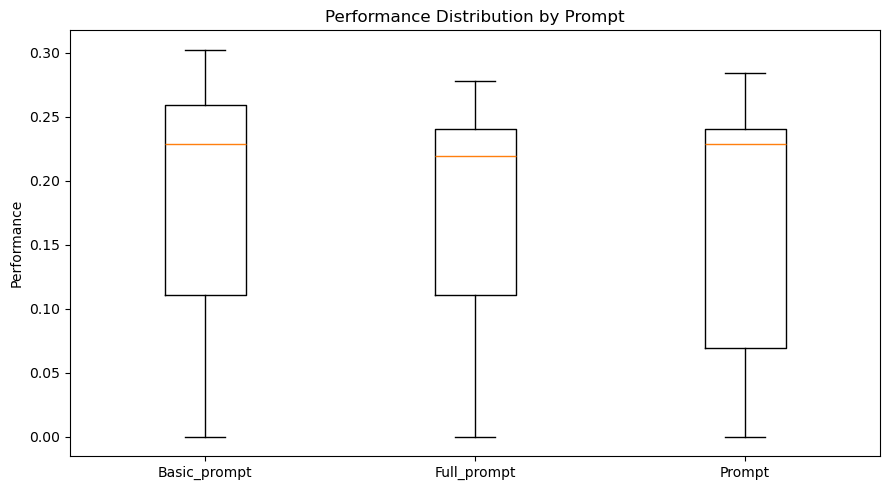

In [123]:
# Boxplots
plt.figure(figsize=(9,5))
plt.boxplot([df.loc[p].values.flatten() for p in prompts],
            labels=[p.capitalize() for p in prompts])
plt.title('Performance Distribution by Prompt')
plt.ylabel('Performance')
plt.tight_layout()
plt.show()

full_prompt partial


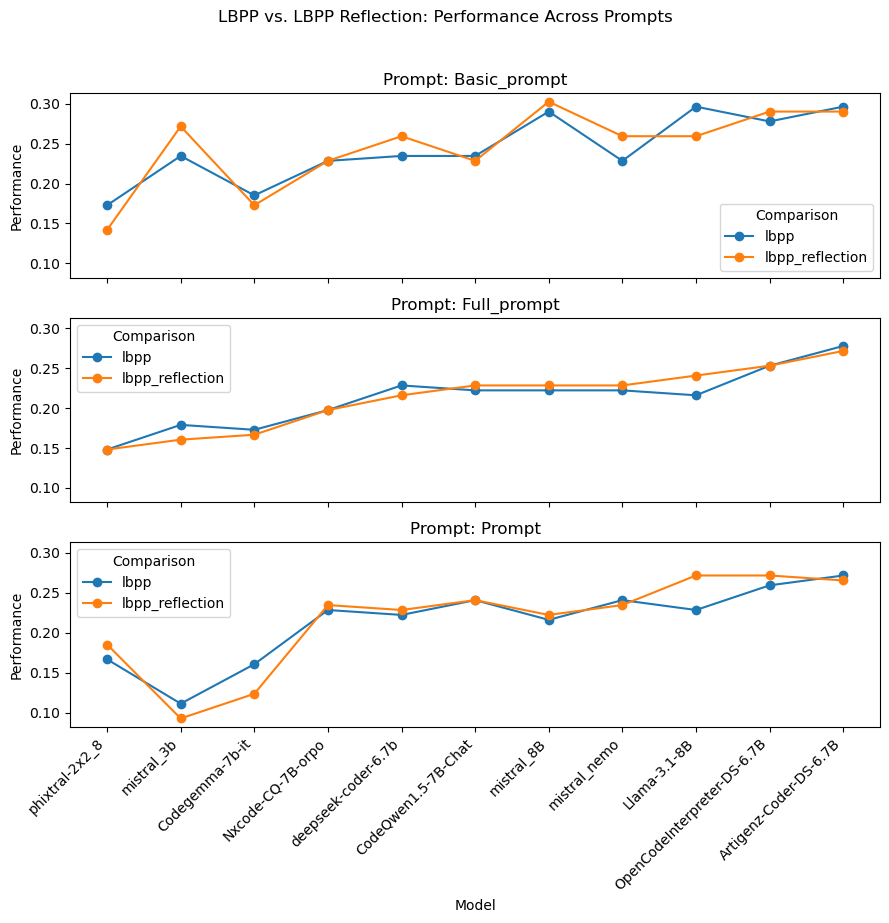

In [142]:
prompts   = df.index.levels[0]
cleanings = df.index.levels[1]

# get the first prompt ('basic_prompt') and sort by 'full' cleaning
selected_prompt   = prompts[1]
seleceted_cleaning = cleanings[2]
print(selected_prompt, seleceted_cleaning)
y_full_clean   = lbpp_reflection_scores.loc[(selected_prompt, seleceted_cleaning)]  # Series indexed by model_cols
sorted_models  = y_full_clean.sort_values().index.tolist()                          # ascending order

# plot each prompt using that sorted_models on the x-axis
fig, axes = plt.subplots(len(prompts), 1,
                         figsize=(9, 3 * len(prompts)),
                         sharex=True, sharey=True)

for ax, prompt in zip(axes, prompts):
    y1 = lbpp_scores.loc[(prompt, seleceted_cleaning), sorted_models]
    y2 = lbpp_reflection_scores.loc[(prompt, seleceted_cleaning), sorted_models]
    ax.plot(range(len(sorted_models)), y1, marker='o', label='lbpp')
    ax.plot(range(len(sorted_models)), y2, marker='o', label='lbpp_reflection')

    ax.set_title(f'Prompt: {prompt.capitalize()}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Performance')
    ax.legend(title='Comparison')

# only label the bottom x-axis
axes[-1].set_xlabel('Model')

fig.suptitle('LBPP vs. LBPP Reflection: Performance Across Prompts', y=1.02)
plt.tight_layout()
plt.show()

In [127]:
sorted_models

['phixtral-2x2_8',
 'Codegemma-7b-it',
 'mistral_3b',
 'CodeQwen1.5-7B-Chat',
 'Nxcode-CQ-7B-orpo',
 'mistral_8B',
 'Llama-3.1-8B',
 'mistral_nemo',
 'deepseek-coder-6.7b',
 'Artigenz-Coder-DS-6.7B',
 'OpenCodeInterpreter-DS-6.7B']

## MBPP Reflection

In [71]:
file = '/Users/andrew/Documents/04_git/code-generation/0_documents/2_docs/indiv_model_results_20250322.xlsx'
mbpp_reflection = pd.read_excel(file, sheet_name='MBPP_Reflection')
mbpp_reflection

# dataset        prompt    cleaning  temperature  top_p  phixtral-2x2_8  \
0    1    mbpp  basic_prompt         raw            1      1           0.000   
1    2    mbpp  basic_prompt     partial            1      1           0.426   
2    3    mbpp  basic_prompt        full            1      1           0.426   
3    4    mbpp  basic_prompt  full_light            1      1           0.426   
4    5    mbpp        prompt         raw            1      1           0.000   
5    6    mbpp        prompt     partial            1      1           0.498   
6    7    mbpp        prompt        full            1      1           0.496   
7    8    mbpp        prompt  full_light            1      1           0.498   
8    9    mbpp   full_prompt         raw            1      1           0.008   
9   10    mbpp   full_prompt     partial            1      1           0.462   
10  11    mbpp   full_prompt        full            1      1           0.470   
11  12    mbpp   full_prompt  full_light            1      1           0.470   

    phixtral-4x2_8  Solar-10.7B  Llama-3.1-8B  Codegemma-7b-it  \
0            0.000        0.000         0.000            0.000   
1            0.426        0.148         0.358            0.416   
2            0.426        0.148         0.360            0.430   
3            0.426        0.148         0.358            0.416   
4            0.000        0.000         0.000            0.000   
5            0.498        0.408         0.000            0.520   
6            0.496        0.410         0.450            0.520   
7            0.498        0.408         0.438            0.520   
8            0.008        0.000         0.000            0.000   
9            0.462        0.380         0.002            0.530   
10           0.470        0.380         0.554            0.530   
11           0.470        0.380         0.554            0.530   

    deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
0                 0.000                        0.000                   0.000   
1                 0.504                        0.374                   0.426   
2                 0.518                        0.378                   0.446   
3                 0.504                        0.374                   0.426   
4                 0.000                        0.000                   0.000   
5                 0.532                        0.498                   0.492   
6                 0.540                        0.560                   0.494   
7                 0.532                        0.560                   0.494   
8                 0.000                        0.000                   0.000   
9                 0.596                        0.634                   0.454   
10                0.596                        0.634                   0.550   
11                0.596                        0.634                   0.548   

    CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  mistral_3b  \
0                 0.000              0.000       0.000       0.000   
1                 0.616              0.598       0.264       0.490   
2                 0.616              0.598       0.288       0.506   
3                 0.616              0.598       0.264       0.490   
4                 0.000              0.000       0.000       0.000   
5                 0.574              0.574       0.306       0.064   
6                 0.574              0.574       0.298       0.496   
7                 0.574              0.574       0.306       0.496   
8                 0.000              0.000       0.000       0.000   
9                 0.706              0.704       0.286       0.452   
10                0.706              0.704       0.286       0.516   
11                0.706              0.704       0.286       0.516   

    mistral_8B  mistral_nemo  codestral_mamba  
0        0.000         0.000            0.000  
1        0.462         0.416            0.382  
2        

In [72]:
# Identify & select only the 15 SLM model columns
param_cols = ['#', 'dataset', 'prompt', 'cleaning', 'temperature', 'top_p']
score_cols = [c for c in mbpp_reflection.columns if c not in param_cols]
mbpp_reflection_scores = mbpp_reflection[score_cols].apply(pd.to_numeric, errors='coerce')

# Rebuild MultiIndex on rows from the original prompt/cleaning columns
mi = pd.MultiIndex.from_frame(mbpp_reflection[['prompt','cleaning']])
mbpp_reflection_scores.index = mi
mbpp_reflection_scores.index.names = ['prompt','cleaning']
mbpp_reflection_scores

phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  \
prompt       cleaning                                                  
basic_prompt raw                  0.000           0.000        0.000   
             partial              0.426           0.426        0.148   
             full                 0.426           0.426        0.148   
             full_light           0.426           0.426        0.148   
prompt       raw                  0.000           0.000        0.000   
             partial              0.498           0.498        0.408   
             full                 0.496           0.496        0.410   
             full_light           0.498           0.498        0.408   
full_prompt  raw                  0.008           0.008        0.000   
             partial              0.462           0.462        0.380   
             full                 0.470           0.470        0.380   
             full_light           0.470           0.470        0.380   

                         Llama-3.1-8B  Codegemma-7b-it  deepseek-coder-6.7b  \
prompt       cleaning                                                         
basic_prompt raw                0.000            0.000                0.000   
             partial            0.358            0.416                0.504   
             full               0.360            0.430                0.518   
             full_light         0.358            0.416                0.504   
prompt       raw                0.000            0.000                0.000   
             partial            0.000            0.520                0.532   
             full               0.450            0.520                0.540   
             full_light         0.438            0.520                0.532   
full_prompt  raw                0.000            0.000                0.000   
             partial            0.002            0.530                0.596   
             full               0.554            0.530                0.596   
             full_light         0.554            0.530                0.596   

                         OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
prompt       cleaning                                                          
basic_prompt raw                               0.000                   0.000   
             partial                           0.374                   0.426   
             full                              0.378                   0.446   
             full_light                        0.374                   0.426   
prompt       raw                               0.000                   0.000   
             partial                           0.498                   0.492   
             full                              0.560                   0.494   
             full_light                        0.560                   0.494   
full_prompt  raw                               0.000                   0.000   
             partial                           0.634                   0.454   
             full                              0.634                   0.550   
             full_light                        0.634                   0.548   

                         CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
prompt       cleaning                                                         
basic_prompt raw                       0.000              0.000       0.000   
             partial                   0.616              0.598       0.264   
             full                      0.616              0.598       0.288   
             full_light                0.616              0.598       0.264   
prompt       raw                       0.000              0.000       0.000   
             partial                   0.574              0.574       0.306   
             full                      0.574              0.574       0.298   
             full_light                0.574              0.574       0.306  

In [73]:
# generic name not to re-write code for each dataset
df = mbpp_reflection_scores

full


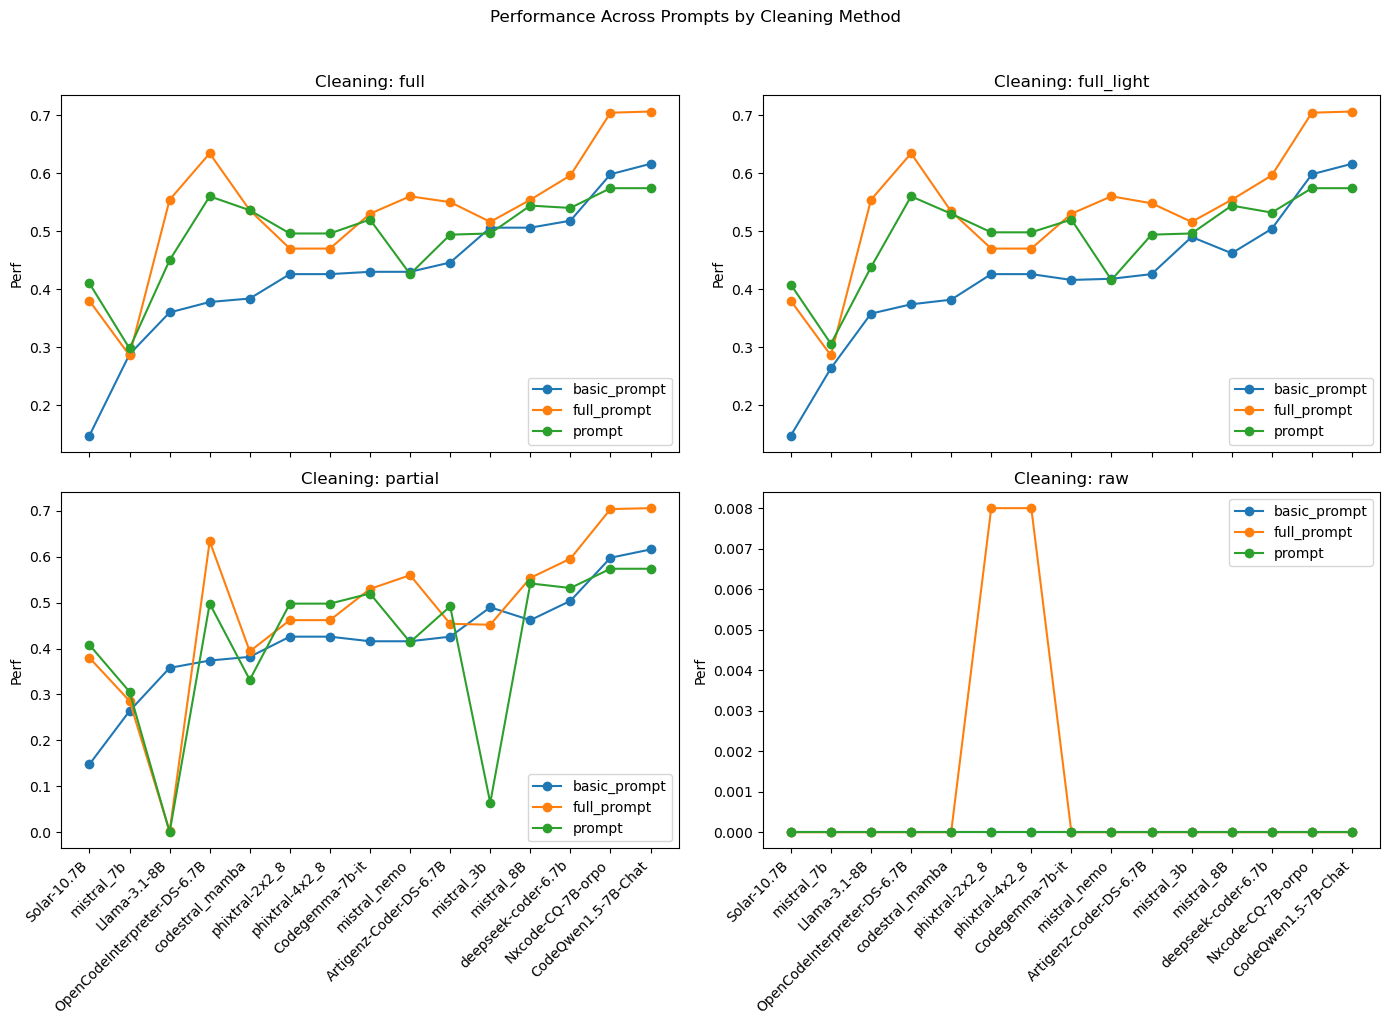

In [74]:
cleanings = df.index.levels[1]
prompts   = df.index.levels[0]

# get the first cleaning ('full') and sort by basic_prompt
first_clean = cleanings[0]
print(first_clean)
y_basic = df.loc[("basic_prompt", first_clean)]               # Series indexed by score_cols
sorted_models = y_basic.sort_values().index.tolist()            # ascending order of basic_prompt

# plot using that same sorted_models order
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

for ax, clean in zip(axes.flatten(), cleanings):
    for prompt in prompts:
        y = df.loc[(prompt, clean), sorted_models]
        ax.plot(range(len(sorted_models)), y, marker='o', label=prompt)
    ax.set_title(f'Cleaning: {clean}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Perf')
    ax.legend()

fig.suptitle('Performance Across Prompts by Cleaning Method', y=1.02)
plt.tight_layout()
plt.show()

basic_prompt


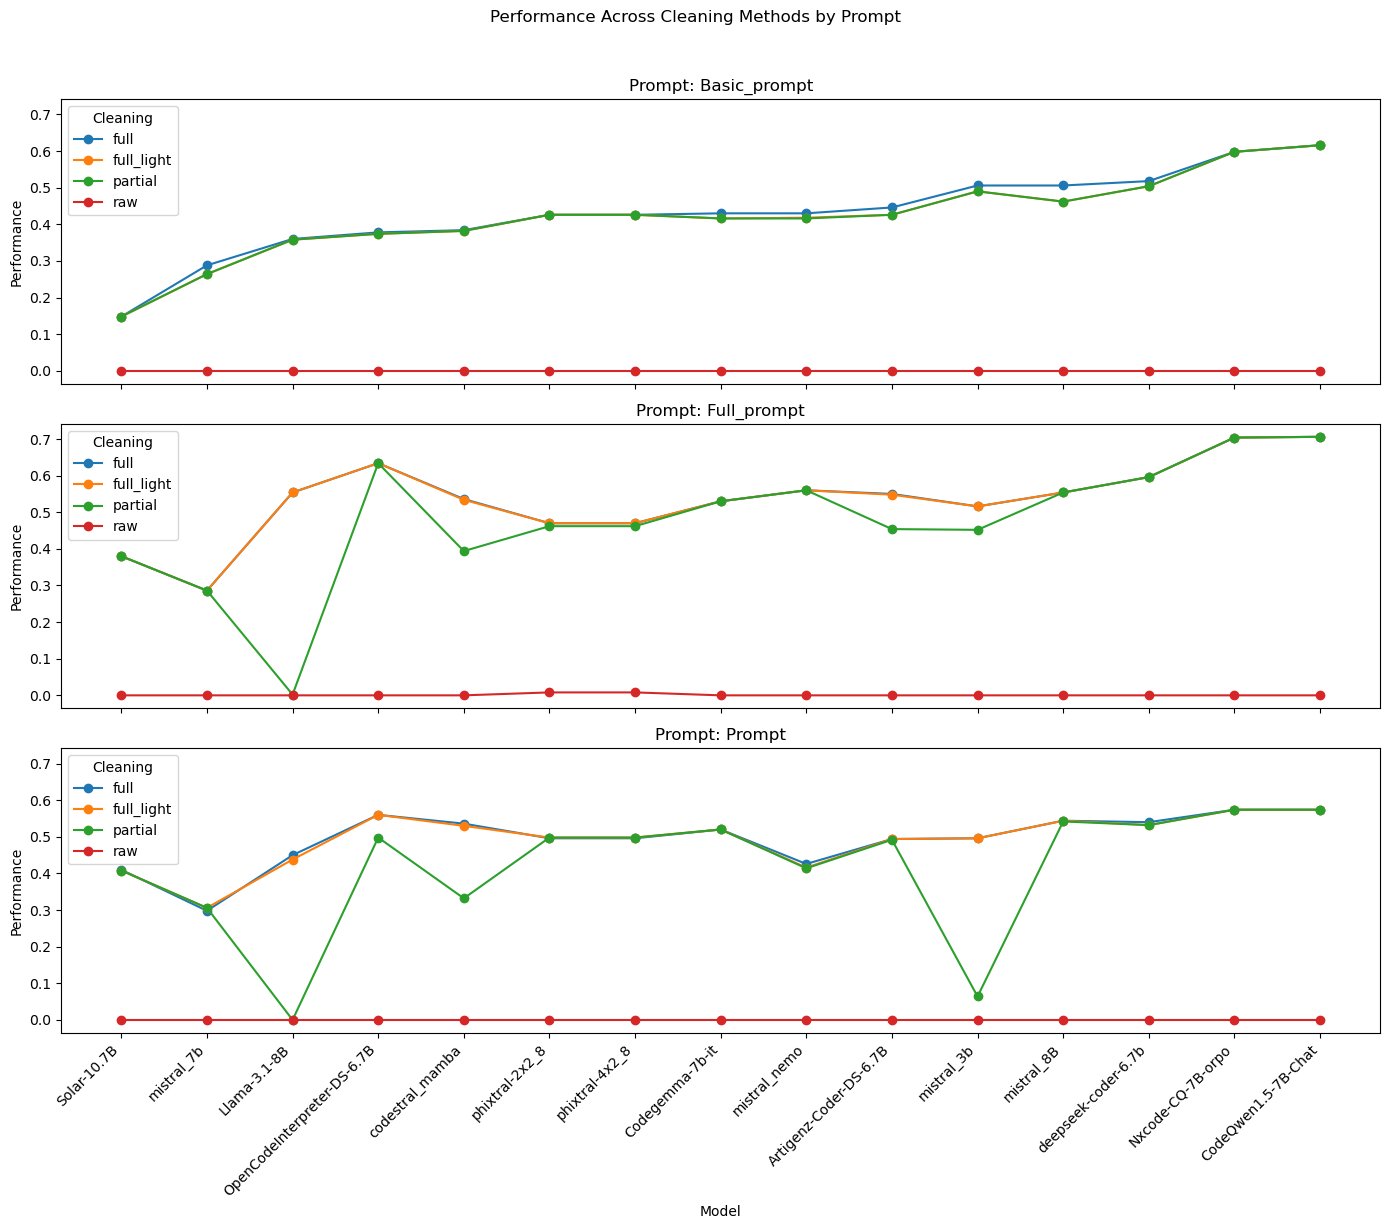

In [75]:
prompts   = df.index.levels[0]
cleanings = df.index.levels[1]

# get the first prompt ('basic_prompt') and sort by 'full' cleaning
first_prompt   = prompts[0]
print(first_prompt)
y_full_clean   = df.loc[(first_prompt, 'full')]                    # Series indexed by model_cols
sorted_models  = y_full_clean.sort_values().index.tolist()         # ascending order

# plot each prompt using that sorted_models on the x-axis
fig, axes = plt.subplots(len(prompts), 1,
                         figsize=(14, 4 * len(prompts)),
                         sharex=True, sharey=True)

for ax, prompt in zip(axes, prompts):
    for clean in cleanings:
        # grab and re-order the y-values by sorted_models
        y = df.loc[(prompt, clean), sorted_models]
        ax.plot(range(len(sorted_models)), y, marker='o', label=clean)

    ax.set_title(f'Prompt: {prompt.capitalize()}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Performance')
    ax.legend(title='Cleaning')

# only label the bottom x-axis
axes[-1].set_xlabel('Model')

fig.suptitle('Performance Across Cleaning Methods by Prompt', y=1.02)
plt.tight_layout()
plt.show()

In [76]:
row_means = df.mean(axis=1)
print(row_means)

prompt        cleaning  
basic_prompt  raw           0.000000
              partial       0.420400
              full          0.430667
              full_light    0.420533
prompt        raw           0.000000
              partial       0.416800
              full          0.494267
              full_light    0.492533
full_prompt   raw           0.001067
              partial       0.478400
              full          0.536400
              full_light    0.536133
dtype: float64


In [77]:
row_max = df.max(axis=1)
print(row_max)

prompt        cleaning  
basic_prompt  raw           0.000
              partial       0.616
              full          0.616
              full_light    0.616
prompt        raw           0.000
              partial       0.574
              full          0.574
              full_light    0.574
full_prompt   raw           0.008
              partial       0.706
              full          0.706
              full_light    0.706
dtype: float64


In [78]:
# compute column‐wise means and maxima
col_means = df.mean(axis=0).sort_values()
col_maxes = df.max(axis=0).sort_values()

# print each Series (index = model names)
print("Column‐wise means:\n", col_means, "\n", sep='')
print("Column‐wise maxima:\n", col_maxes, "\n", sep='')

max_locs = df.idxmax(axis=0)
print("Max locations:\n", max_locs, sep='')

Column‐wise means:
mistral_7b                     0.215333
Solar-10.7B                    0.234167
Llama-3.1-8B                   0.256167
codestral_mamba                0.334167
mistral_3b                     0.335500
phixtral-2x2_8                 0.348333
phixtral-4x2_8                 0.348333
mistral_nemo                   0.350000
Artigenz-Coder-DS-6.7B         0.360833
Codegemma-7b-it                0.367667
OpenCodeInterpreter-DS-6.7B    0.387167
mistral_8B                     0.393500
deepseek-coder-6.7b            0.409833
Nxcode-CQ-7B-orpo              0.469000
CodeQwen1.5-7B-Chat            0.474000
dtype: float64

Column‐wise maxima:
mistral_7b                     0.306
Solar-10.7B                    0.410
phixtral-2x2_8                 0.498
phixtral-4x2_8                 0.498
mistral_3b                     0.516
Codegemma-7b-it                0.530
codestral_mamba                0.536
Artigenz-Coder-DS-6.7B         0.550
Llama-3.1-8B                   0.554
mistral_8B  

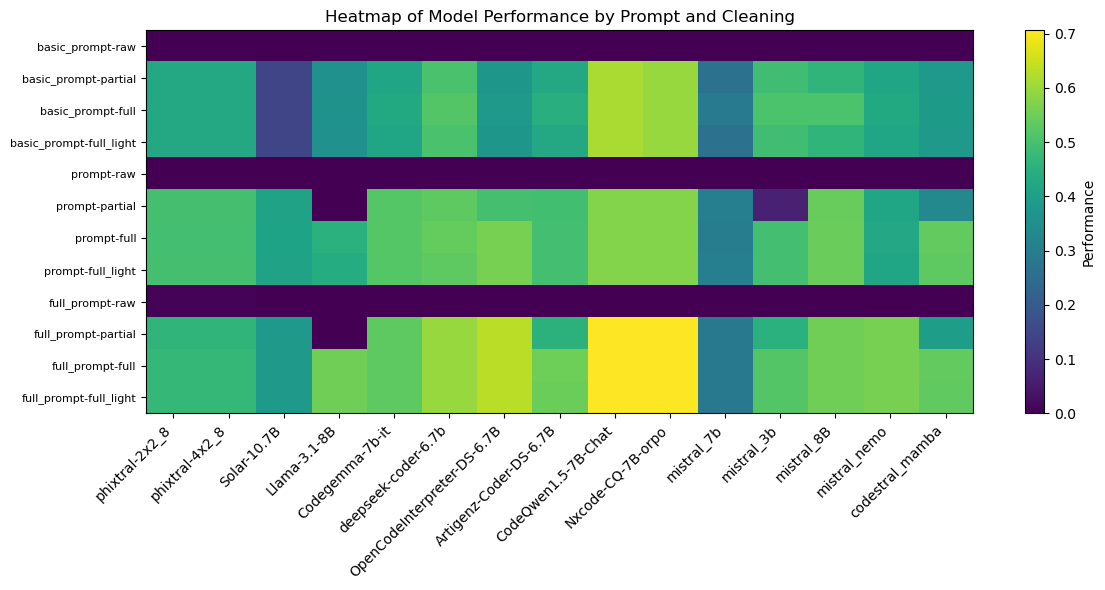

In [79]:
# Heatmap
plt.figure(figsize=(12,6))
plt.imshow(df.values.astype(float), aspect='auto', cmap='viridis')
plt.colorbar(label='Performance')
plt.xticks(range(len(score_cols)), score_cols, rotation=45, ha='right')
plt.yticks(range(len(df.index)), [f"{p}-{c}" for p,c in df.index], fontsize=8)
plt.title('Heatmap of Model Performance by Prompt and Cleaning')
plt.tight_layout()
plt.show()

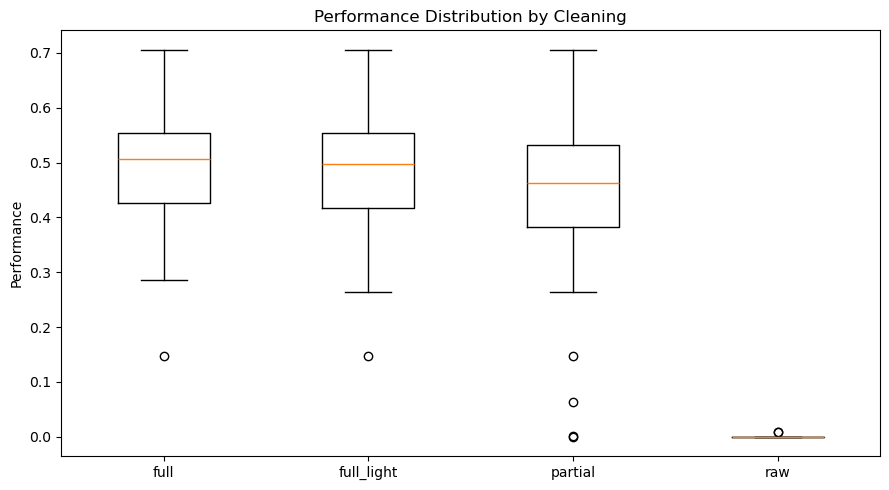

In [80]:
plt.figure(figsize=(9,5))
plt.boxplot([df.xs(c, level='cleaning').values.flatten() for c in cleanings],
            labels=cleanings)
plt.title('Performance Distribution by Cleaning')
plt.ylabel('Performance')
plt.tight_layout()
plt.show()

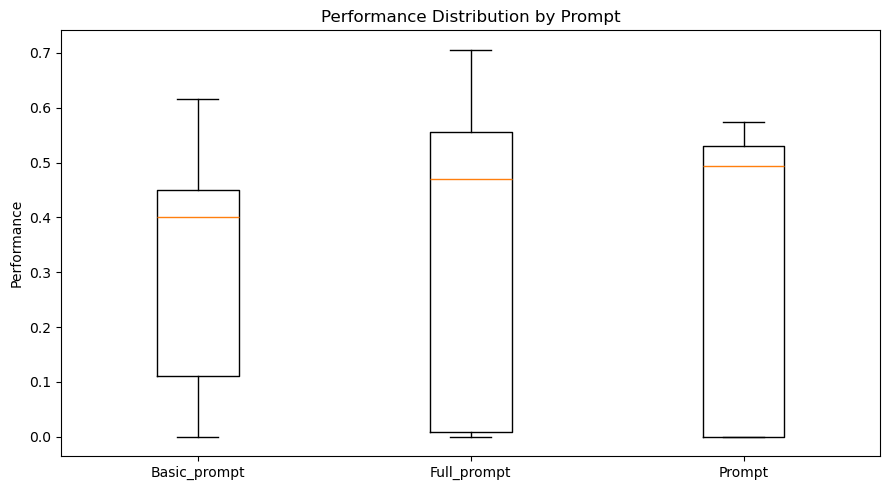

In [81]:
# Boxplots
plt.figure(figsize=(9,5))
plt.boxplot([df.loc[p].values.flatten() for p in prompts],
            labels=[p.capitalize() for p in prompts])
plt.title('Performance Distribution by Prompt')
plt.ylabel('Performance')
plt.tight_layout()
plt.show()

In [83]:
prompts   = df.index.levels[0]
cleanings = df.index.levels[1]
mbpp_reflection_scores

phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  \
prompt       cleaning                                                  
basic_prompt raw                  0.000           0.000        0.000   
             partial              0.426           0.426        0.148   
             full                 0.426           0.426        0.148   
             full_light           0.426           0.426        0.148   
prompt       raw                  0.000           0.000        0.000   
             partial              0.498           0.498        0.408   
             full                 0.496           0.496        0.410   
             full_light           0.498           0.498        0.408   
full_prompt  raw                  0.008           0.008        0.000   
             partial              0.462           0.462        0.380   
             full                 0.470           0.470        0.380   
             full_light           0.470           0.470        0.380   

                         Llama-3.1-8B  Codegemma-7b-it  deepseek-coder-6.7b  \
prompt       cleaning                                                         
basic_prompt raw                0.000            0.000                0.000   
             partial            0.358            0.416                0.504   
             full               0.360            0.430                0.518   
             full_light         0.358            0.416                0.504   
prompt       raw                0.000            0.000                0.000   
             partial            0.000            0.520                0.532   
             full               0.450            0.520                0.540   
             full_light         0.438            0.520                0.532   
full_prompt  raw                0.000            0.000                0.000   
             partial            0.002            0.530                0.596   
             full               0.554            0.530                0.596   
             full_light         0.554            0.530                0.596   

                         OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
prompt       cleaning                                                          
basic_prompt raw                               0.000                   0.000   
             partial                           0.374                   0.426   
             full                              0.378                   0.446   
             full_light                        0.374                   0.426   
prompt       raw                               0.000                   0.000   
             partial                           0.498                   0.492   
             full                              0.560                   0.494   
             full_light                        0.560                   0.494   
full_prompt  raw                               0.000                   0.000   
             partial                           0.634                   0.454   
             full                              0.634                   0.550   
             full_light                        0.634                   0.548   

                         CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
prompt       cleaning                                                         
basic_prompt raw                       0.000              0.000       0.000   
             partial                   0.616              0.598       0.264   
             full                      0.616              0.598       0.288   
             full_light                0.616              0.598       0.264   
prompt       raw                       0.000              0.000       0.000   
             partial                   0.574              0.574       0.306   
             full                      0.574              0.574       0.298   
             full_light                0.574              0.574       0.306  

In [94]:
#mbpp_reflection.loc[('basic_prompt', 'full')]
mbpp_reflection

# dataset        prompt    cleaning  temperature  top_p  phixtral-2x2_8  \
0    1    mbpp  basic_prompt         raw            1      1           0.000   
1    2    mbpp  basic_prompt     partial            1      1           0.426   
2    3    mbpp  basic_prompt        full            1      1           0.426   
3    4    mbpp  basic_prompt  full_light            1      1           0.426   
4    5    mbpp        prompt         raw            1      1           0.000   
5    6    mbpp        prompt     partial            1      1           0.498   
6    7    mbpp        prompt        full            1      1           0.496   
7    8    mbpp        prompt  full_light            1      1           0.498   
8    9    mbpp   full_prompt         raw            1      1           0.008   
9   10    mbpp   full_prompt     partial            1      1           0.462   
10  11    mbpp   full_prompt        full            1      1           0.470   
11  12    mbpp   full_prompt  full_light            1      1           0.470   

    phixtral-4x2_8  Solar-10.7B  Llama-3.1-8B  Codegemma-7b-it  \
0            0.000        0.000         0.000            0.000   
1            0.426        0.148         0.358            0.416   
2            0.426        0.148         0.360            0.430   
3            0.426        0.148         0.358            0.416   
4            0.000        0.000         0.000            0.000   
5            0.498        0.408         0.000            0.520   
6            0.496        0.410         0.450            0.520   
7            0.498        0.408         0.438            0.520   
8            0.008        0.000         0.000            0.000   
9            0.462        0.380         0.002            0.530   
10           0.470        0.380         0.554            0.530   
11           0.470        0.380         0.554            0.530   

    deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
0                 0.000                        0.000                   0.000   
1                 0.504                        0.374                   0.426   
2                 0.518                        0.378                   0.446   
3                 0.504                        0.374                   0.426   
4                 0.000                        0.000                   0.000   
5                 0.532                        0.498                   0.492   
6                 0.540                        0.560                   0.494   
7                 0.532                        0.560                   0.494   
8                 0.000                        0.000                   0.000   
9                 0.596                        0.634                   0.454   
10                0.596                        0.634                   0.550   
11                0.596                        0.634                   0.548   

    CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  mistral_3b  \
0                 0.000              0.000       0.000       0.000   
1                 0.616              0.598       0.264       0.490   
2                 0.616              0.598       0.288       0.506   
3                 0.616              0.598       0.264       0.490   
4                 0.000              0.000       0.000       0.000   
5                 0.574              0.574       0.306       0.064   
6                 0.574              0.574       0.298       0.496   
7                 0.574              0.574       0.306       0.496   
8                 0.000              0.000       0.000       0.000   
9                 0.706              0.704       0.286       0.452   
10                0.706              0.704       0.286       0.516   
11                0.706              0.704       0.286       0.516   

    mistral_8B  mistral_nemo  codestral_mamba  
0        0.000         0.000            0.000  
1        0.462         0.416            0.382  
2        

basic_prompt


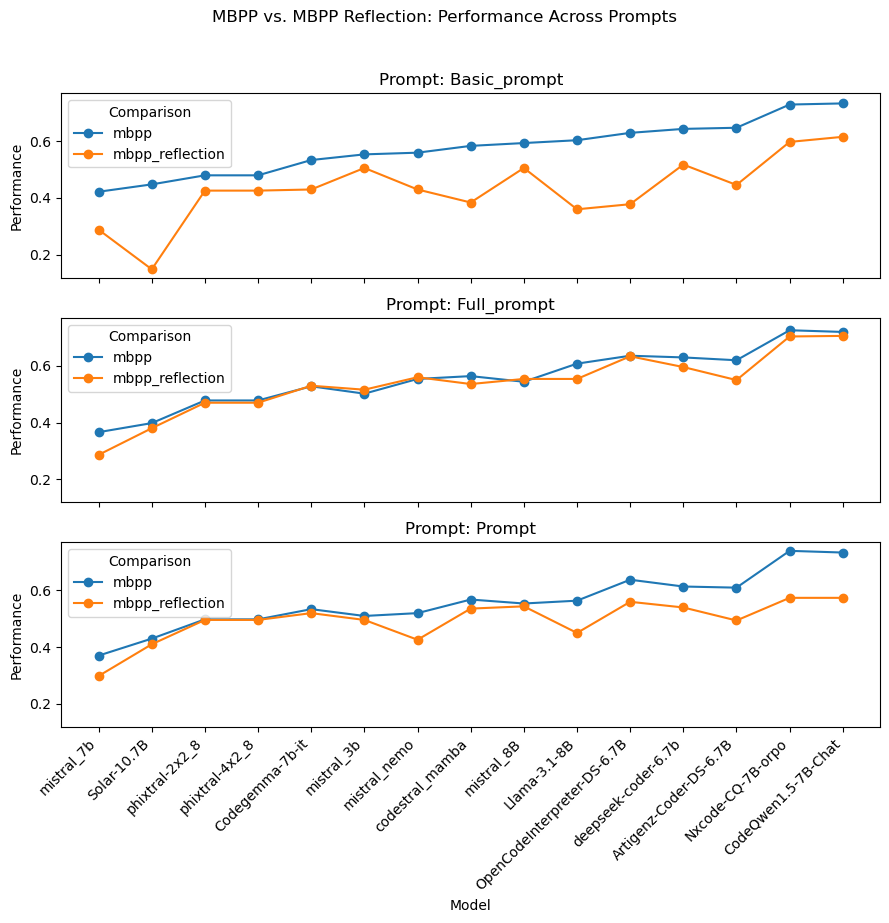

In [106]:
prompts   = df.index.levels[0]
cleanings = df.index.levels[1]

# get the first prompt ('basic_prompt') and sort by 'full' cleaning
first_prompt   = prompts[0]
print(first_prompt)
y_full_clean   = mbpp_scores.loc[(first_prompt, 'full')]                    # Series indexed by model_cols
sorted_models  = y_full_clean.sort_values().index.tolist()                  # ascending order

# plot each prompt using that sorted_models on the x-axis
fig, axes = plt.subplots(len(prompts), 1,
                         figsize=(9, 3 * len(prompts)),
                         sharex=True, sharey=True)

for ax, prompt in zip(axes, prompts):
    y1 = mbpp_scores.loc[(prompt, 'full'), sorted_models]
    y2 = mbpp_reflection_scores.loc[(prompt, 'full'), sorted_models]
    ax.plot(range(len(sorted_models)), y1, marker='o', label='mbpp')
    ax.plot(range(len(sorted_models)), y2, marker='o', label='mbpp_reflection')

    ax.set_title(f'Prompt: {prompt.capitalize()}')
    ax.set_xticks(range(len(sorted_models)))
    ax.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax.set_ylabel('Performance')
    ax.legend(title='Comparison')

# only label the bottom x-axis
axes[-1].set_xlabel('Model')

fig.suptitle('MBPP vs. MBPP Reflection: Performance Across Prompts', y=1.02)
plt.tight_layout()
plt.show()

# 3. Ranking models

In [7]:
from IPython.display import display, HTML

cols_text = ['Model', 'Model_Size', 'License']
df_text = df[cols_text]                              # text column(s)
df_numeric = df.drop(columns = cols_text)            # numeric columns
df_numeric['Average'] = df_numeric.mean(axis=1)
df_result = df_text.join(df_numeric)
print(df_result.shape)

# display(HTML(df_result.to_html())) - prints the same
df_result.sort_values(by='Average', ascending=False).reset_index(drop=True)

(15, 10)


Model  Model_Size               License   #  \
0                  Mistral 7B        7.00               Apache2  15   
1                Mistral-Nemo       12.00               Apache2  14   
2                Ministral 3B        3.00    Mistral_Commercial  13   
3                Ministral 8B        8.00    Mistral_Commercial  12   
4             Codestral Mamba        7.30               Apache2  11   
5              Phixtral-4x2_8        7.80                   MIT  10   
6              Phixtral-2x2_8        4.50                   MIT   9   
7   Nous-Hermes-2-SOLAR-10.7B       10.70              Apache 2   8   
8               Code Gemma 7B        7.00  free_responsible_use   7   
9         Artigenz-Coder-6.7B        6.70  free_responsible_use   6   
10        OpenCodeInterpreter        6.70              Apache 2   5   
11                CodeQwen-7B        7.00       free_100M_users   4   
12               Llama 3.1 8B        8.00       free_700M_users   3   
13          Nxcode-CQ-7B-orpo        7.25       free_100M_users   1   
14             Deepseek-Coder        6.70              free_use   2   

    HumanEval_Full  HumanEval_Complete   MBPP    LBPP  Big_Code_Bench  \
0           0.3110             0.35980  0.136  0.0990           0.156   
1           0.5854             0.53050  0.474  0.2160           0.172   
2           0.6463             0.61590  0.518  0.2099           0.268   
3           0.7256             0.71340  0.562  0.2222           0.246   
4           0.7561             0.60370  0.394  0.2654           0.230   
5           0.0000             0.00000  0.000  0.0000           0.000   
6           0.1464             0.34756  0.146  0.0490           0.206   
7           0.2561             0.28650  0.304  0.0800           0.434   
8           0.0000             0.27440  0.510  0.1914           0.024   
9           0.0122             0.73170  0.002  0.0432           0.134   
10          0.4100             0.71950  0.054  0.0800           0.322   
11          0.5000             0.54880  0.552  0.1975           0.268   
12          0.6590             0.55470  0.568  0.2160           0.298   
13          0.8293             0.75610  0.730  0.2284           0.240   
14          0.6524             0.70730  0.010  0.0000           0.322   

     Average  
0   2.676967  
1   2.662983  
2   2.543017  
3   2.411533  
4   2.208200  
5   1.666667  
6   1.649160  
7   1.560100  
8   1.333300  
9   1.153850  
10  1.097583  
11  1.011050  
12  0.882617  
13  0.630633  
14  0.615283

In [8]:
from tabulate import tabulate
print(tabulate(df_result, headers='keys', tablefmt='presto'))

    | Model                     |   Model_Size | License              |   # |   HumanEval_Full |   HumanEval_Complete |   MBPP |   LBPP |   Big_Code_Bench |   Average
----+---------------------------+--------------+----------------------+-----+------------------+----------------------+--------+--------+------------------+-----------
  0 | Nxcode-CQ-7B-orpo         |         7.25 | free_100M_users      |   1 |           0.8293 |              0.7561  |  0.73  | 0.2284 |            0.24  |  0.630633
  1 | Deepseek-Coder            |         6.7  | free_use             |   2 |           0.6524 |              0.7073  |  0.01  | 0      |            0.322 |  0.615283
  2 | Llama 3.1 8B              |         8    | free_700M_users      |   3 |           0.659  |              0.5547  |  0.568 | 0.216  |            0.298 |  0.882617
  3 | CodeQwen-7B               |         7    | free_100M_users      |   4 |           0.5    |              0.5488  |  0.552 | 0.1975 |            0.268 |  1.0110

## 4. Scaling Results (Unnecessary) and Ranking Models
Keeping this here as an option, although unnecessary one

In [39]:
# scaling results to calculate the rank of each model
from sklearn.preprocessing import MinMaxScaler

cols_text = ['Model', 'Model_Size', 'License']
df_text = df[cols_text]                              # text column(s)
df_numeric = df.drop(columns = cols_text)            # numeric columns

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_numeric),
    columns=df_numeric.columns,
    index=df_numeric.index
)
df_scaled['Average'] = df_scaled.mean(axis=1)
df_result = df_text.join(df_scaled)

df_result.sort_values(by='Average', ascending=False)

KeyError: "None of [Index(['Model', 'Model_Size', 'License'], dtype='object')] are in the [columns]"

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def scale_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a DataFrame where all original columns are present,
    but any numeric columns have been min–max scaled to [0,1].
    """
    # 1. Copy to avoid modifying in place
    df_scaled = df.copy()
    
    # 2. Identify numeric columns
    num_cols = df_scaled.select_dtypes(include=[np.number]).columns.tolist()
    
    if not num_cols:
        # nothing to scale
        return df_scaled
    
    # 3. Fit-transform scaler on those columns
    scaler = MinMaxScaler()
    df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])
    
    return df_scaled

# Example
df = pd.DataFrame({
    'age':    [23, 45, 31, 54],
    'income': [30_000, 75_000, 50_000, 100_000],
    'score':  [0.1, 0.4, 0.2, 0.8],
    'city':   ['A', 'B', 'C', 'A']
})

scaled_df = scale_numeric_columns(df)
print(scaled_df)

In [ ]:
# pastel colors
pastel_colors = [
    "#FFB347",  # Pastel orange
    "#8BAED5",  # Pastel blue
    "#77DD77",  # Pastel green
    "#FF9999",  # Pastel gray
    "#B683B6"   # Pastel purple
]